# Notes:


This notebook is an update of Pipe_LSS_Analysis_3.ipynb.

It analyses the results of the dDM/dz values created in Pipe_Creation_Plus_LSS_8.ipynb and raven:/u/cwalker/Illustris_Zhang_Method/ batch_jobs/batch_scripts/make_pipes_2.py

It analyses large scale structure content of pipes. It studies both the DM contributions, and the total cell number contributions. It also compares the zhang method (removing star forming regions) to the Pakmor method where a correction is applied to star forming regions by muliplying ElectronAbundance by a warm-phase gas mass fraction, w. Finally, it can analyse subhalos traversed by pipes and impact factors.

It continues using the method described in Zhang+20: https://arxiv.org/abs/2011.14494
The Pakmor correction is described in Pakmor+18: https://arxiv.org/abs/1807.02113
It is defined as 1-X where X is from Marinacci+17: https://arxiv.org/abs/1610.01594
The correction is used for FRB purposes in, e.g.: ??? (I know there's one)



# Imports:

In [115]:
import os

import numpy as np
import illustris_python as il

from frb.dm import igm
from charlie_TNG_tools import temp2u
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource
from astropy.modeling import models, fitting

# Functions

In [116]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100),density=True):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    density : [boolean] True or False: whether the histogram should normalise for the pdf or not.
    """
    
    return np.histogram(data,bins=bins,density=density)[0]

In [117]:
#function to darken colours in plots from: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Load Theory

In [118]:
#get theory for next plot
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0,3.0,4.0])#,5.0])#,6.0,7.0,8.0, 9.0])
print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


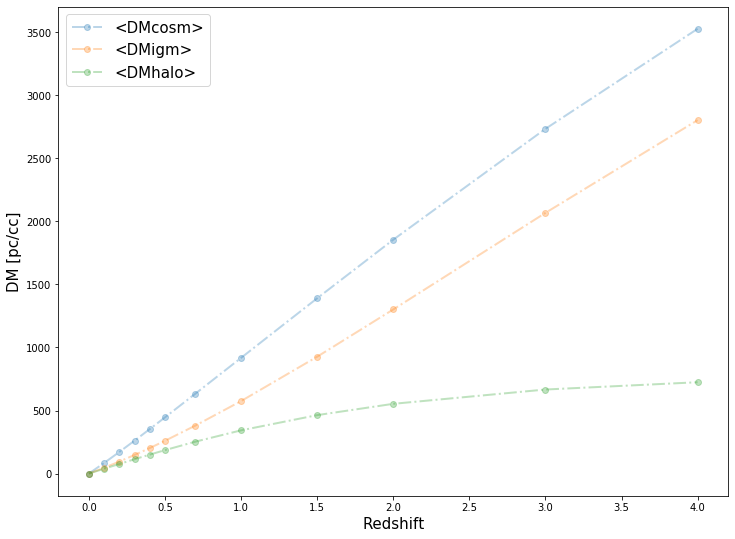

In [119]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()


# Load pipe dDM/dz values

In [152]:
#############################
#Identify files to be loaded#
#############################

#simulation to load data for
sim_to_load = 'TNG300-1'

#path to simulation data
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)


#base directory containing pipe files
if sim_to_load!='TNG300-1': #for smaller simulations the pipes are stored in '.'
    pipeBasePath = './'
else: #for TNG300-1 the pipes are stored in /SpeedTest/
    pipeBasePath = './SpeedTest/'

#load the files from the base path
all_files = os.listdir(pipeBasePath)#for pipes created for smaller simulations

#.npy files
npy_files = [i for i in all_files if '.npy' in i]

#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz_Output' in i]

#correct simulation
dDMdz_files = [i for i in npy_files if sim_to_load in i]

#load version of data with impact factor details for all small simulations
if sim_to_load!='TNG300-1':
    dDMdz_files = [i for i in dDMdz_files if 'pID_test' in i]
else: #load version from speed tests for TNG300-1
     dDMdz_files = [i for i in dDMdz_files if 'SpeedTest' in i]
        
#list of snapshots wth data
snap_list = [int(i.split('_')[3]) for i in dDMdz_files]

#sort into ascending order
dDMdz_files = [x for _, x in sorted(zip(snap_list, dDMdz_files))]
snap_list.sort()

#reverse into descending order
dDMdz_files = dDMdz_files[::-1]
snap_list = snap_list[::-1]

#crop to redshift 5, because that is as far as the theory goes in FRB package.
#Note that after z=3 accuracy 'is not guaranteed'

dDMdz_files = dDMdz_files[0:12]
snap_list = snap_list[0:12]

#print to check
print(snap_list)
print(dDMdz_files)

[99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21]
['Sim_TNG300-1_Snap_99_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_91_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_84_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_78_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_72_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_67_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_59_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_50_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_40_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_33_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_25_dDMdz_Output_SpeedTest.npy', 'Sim_TNG300-1_Snap_21_dDMdz_Output_SpeedTest.npy']


In [153]:
#############################
#Zhang method initialisation#
#############################

dDMdz_dict_Zhang = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Zhang = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Zhang = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Zhang = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Zhang  = {} #initialise dictionary to hold number of halo cells
fila_dict_Zhang  = {} #initialise dictionary to hold number of filament cells
void_dict_Zhang  = {} #initialise dictionary to hold number of void cells

##################################
#Pakmor Correction initialisation#
##################################

dDMdz_dict_Pakmor = {} #initialise dictionary to hold dDMdz values
dDMdz_HaloDict_Pakmor = {} #initialise dictionary to hold the halo dDMdz portion
dDMdz_FilaDict_Pakmor = {} #initialise dictionary to hold the filament dDMdz portion
dDMdz_VoidDict_Pakmor = {} #initialise dictionary to hold the void dDMdz portion

halo_dict_Pakmor  = {} #initialise dictionary to hold number of halo cells
fila_dict_Pakmor  = {} #initialise dictionary to hold number of filament cells
void_dict_Pakmor  = {} #initialise dictionary to hold number of void cells

##############################
#Impact factor initialisation#
##############################

first_ShID_dict     = {} #initialise dictionary to hold the first subhalo ID in each pipe
unique_ShIDs_dict   = {} #initialise dictionary to hold all unique subhalo IDs in each pipe
closest_coords_dict = {} #initialise dictionary to extract pipe coordinates of closest approach to these IDs.

######################
#Other initialisation#
######################

snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

#######################################
#load the files into a data dictionary#
#######################################

#path to data
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
for i in range(len(dDMdz_files)):#loop over files

    #load and extract dats
    snapshot = dDMdz_files[i].split('_')[3] #extract snapshot number
    
    vals = np.load(pipeBasePath+dDMdz_files[i],allow_pickle=True).tolist() #extract values from file
    
    dDMdz_dict_Zhang[snapshot]=vals['dDMdz_Zhang']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key
    dDMdz_dict_Pakmor[snapshot]=vals['dDMdz_Pakmor']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key

    dDMdz_HaloDict_Zhang[snapshot]=vals['dDMdzHalo_Zhang']*u.pc*u.cm**-3 #do same for halo portion
    dDMdz_HaloDict_Pakmor[snapshot]=vals['dDMdzHalo_Pakmor']*u.pc*u.cm**-3 #do same for halo portion

    dDMdz_FilaDict_Zhang[snapshot]=vals['dDMdzFilament_Zhang']*u.pc*u.cm**-3 #do same for filament portion
    dDMdz_FilaDict_Pakmor[snapshot]=vals['dDMdzFilament_Pakmor']*u.pc*u.cm**-3 #do same for filament portion

    dDMdz_VoidDict_Zhang[snapshot]=vals['dDMdzVoid_Zhang']*u.pc*u.cm**-3 #do same for void portion
    dDMdz_VoidDict_Pakmor[snapshot]=vals['dDMdzVoid_Pakmor']*u.pc*u.cm**-3 #do same for void portion

    halo_dict_Zhang[snapshot]=np.array(vals['nHalo_Zhang']) #append number of halo cells to dictionary with snapshot number as key
    halo_dict_Pakmor[snapshot]=np.array(vals['nHalo_Pakmor']) #append number of halo cells to dictionary with snapshot number as key

    fila_dict_Zhang[snapshot]=np.array(vals['nFilament_Zhang']) #append number of filament cells to dictionary with snapshot number as key
    fila_dict_Pakmor[snapshot]=np.array(vals['nFilament_Pakmor']) #append number of filament cells to dictionary with snapshot number as key

    void_dict_Zhang[snapshot]=np.array(vals['nVoid_Zhang']) #append number of void cells to dictionary with snapshot number as key
    void_dict_Pakmor[snapshot]=np.array(vals['nVoid_Pakmor']) #append number of void cells to dictionary with snapshot number as key
 
    first_ShID_dict[snapshot]=np.array(vals['firstShID']) #append first subhalo ID of each pipe
    unique_ShIDs_dict[snapshot]=np.array(vals['uniqueShIDs']) #append all unique subhalo IDs in each pipe
    closest_coords_dict[snapshot]=np.array(vals['closestCoords']) #append closest los coords to these IDs

    header = il.groupcat.loadHeader(basePath,int(snapshot)) #extract simulation and snapshot header
    snap_redshifts[snapshot]=header['Redshift'] #get redshift at this snapshot
    snap_z_list.append(header['Redshift']) #append to array


#print(snap_redshifts['99'])    

#print('totals: {0} ({1})'.format(dDMdz_dict_Zhang['99'],dDMdz_dict_Pakmor['99']))
#print('sum of structures: {0} ({1})'.format(dDMdz_HaloDict_Zhang['99']+dDMdz_FilaDict_Zhang['99']+dDMdz_VoidDict_Zhang['99'],
#                                            dDMdz_HaloDict_Pakmor['99']+dDMdz_FilaDict_Pakmor['99']+dDMdz_VoidDict_Pakmor['99']))
#print(halo_dict_Zhang['99'])
#print(halo_dict_Zhang['99']+fila_dict_Zhang['99']+void_dict_Zhang['99'])
#print(len(snap_redshifts))

#print(halo_dict_Zhang)

#print(len(halo_dict_Zhang['99']),len(halo_dict_Zhang['91']))

#print('impact factor info:')
#print('first subhalo IDs: {0}'.format(first_ShID_dict['99']))
#print('(number unique first subhalos = {0}, uniques = {1})'.format(len(np.unique(first_ShID_dict['99'])),np.unique(first_ShID_dict['99'])))
#print('unique subhalos : {0}'.format(unique_ShIDs_dict['99']))
#print('closest coords to subhalos: {0}'.format(closest_coords_dict['99']))

# Do some quick analyses on the number of subhalos traversed by pipes

No handles with labels found to put in legend.


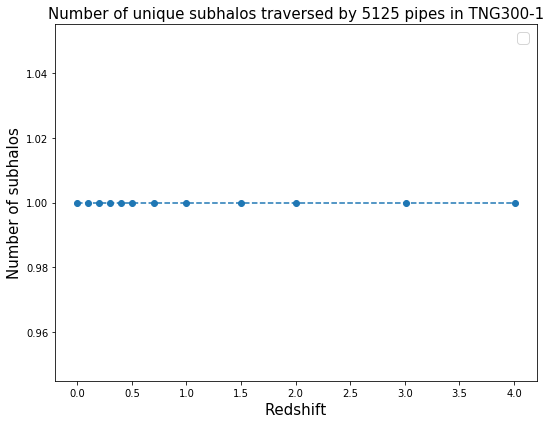

In [154]:
ShIDvsZ  = [] #create an array to hold the complete list of unique subhalo ids traversed by pipes per redshift
nShIDvsZ = [] #create array to hold number of these subhalo ids per redshift

for snap in snap_list:
    vals = np.unique(np.concatenate(unique_ShIDs_dict[str(snap)]).ravel()) #unique subhalo ids
    nvals = len(vals) #number of unique subhalo ids
    ShIDvsZ.append(vals) #append values to array
    nShIDvsZ.append(nvals) #append length to array
    
    

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
ax.set_title('Number of unique subhalos traversed by {0} pipes in {1}'.format(len(unique_ShIDs_dict['91']),sim_to_load),fontsize=15)
ax.set_ylabel('Number of subhalos',fontsize=15)
ax.set_xlabel('Redshift',fontsize=15)

plt.plot(snap_z_list,nShIDvsZ,marker='o',linestyle='--')
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('unique_subhalo_count_{0}.png'.format(sim_to_load),format='png')
plt.show()

# create a dictionary of impact factors to the subhalos traversed by pipes

In [155]:
impact_factor_dict = {} # initialise dictionary

for i in range(len(snap_list)): #loop over snapshots
    snapshot = str(snap_list[i]) #get snapshot number
    print(snapshot)
    dists_snap = [] #initialise array to hold distances to every subhalo in every pipe in snapshot
    subhalos_snap = unique_ShIDs_dict[snapshot] #get snapshot's subhalos traversed
    closests_snap = closest_coords_dict[snapshot] #get closest coordinates to these snapshots
    #print(subhalos,closests)
    #print(subhalos_snap[1],closests_snap[1])
    for j in range(len(subhalos_snap)): #loop over all pipes
        dists_pipe = [] #initialise array to hold distances to every subhalo in this pipe
        subhalos_pipe = np.array(subhalos_snap[j])
        closests_pipe = np.array(closests_snap[j])
        #extract the ones which are not -1
        subhalos_pipe_notneg1 = subhalos_pipe[np.where(subhalos_pipe!=-1)]
        #print(subhalos_pipe,subhalos_pipe_notneg1,closests_pipe)
        #loop over subhalos in pipe which aren't -1 and get impact factors
        for k in range(len(subhalos_pipe_notneg1)): #loop over subhalos
            subhalo = subhalos_pipe_notneg1[k] #select subhalo
            subhalo_closestcoords = closests_pipe[k] #get closest coordinates
            subhalo_data = il.groupcat.loadSingle(basePath,int(snapshot),subhaloID=subhalo)#load subhalo data
            subhalo_pos = subhalo_data['SubhaloPos']
            MinDist = np.sqrt(((subhalo_closestcoords[0]-subhalo_pos[0])**2)+((subhalo_closestcoords[1]-subhalo_pos[1])**2)+((subhalo_closestcoords[2]-subhalo_pos[2])**2))
            dists_pipe.append(MinDist) #append distance to array
        dists_snap.append(np.array(dists_pipe)) #append pipe to array
    impact_factor_dict[snapshot] = np.array(dists_snap) #append snapshot to dictionary
    
print('done')


99
91
84
78
72
67
59
50
40
33
25
21
done


# quickly analyse these impact factors as a function of redshift

[147430.27979184  96155.86166056 129707.56282719 ... 113135.41020313
  66317.94117163  84448.10137068]
[ 36908.93599704 128606.8884682  125488.23979651 ... 149666.18820011
  33047.9491716   59825.58177821]
[114443.75864706 165392.87644656  57884.73834724 ... 131761.463434
  80528.11646965 135230.32526652]
[ 19726.13684516 128515.00292166  93080.65138033 ... 148928.31121655
  17156.52259583 109893.38092252]
[152099.63095791  21220.44543962 179280.60690955 ...  26534.88436377
 134857.4780321   92084.35069258]
[ 77257.26959843  91191.88498597 114543.42087824 ... 121269.78666179
  49402.16680127  25374.66148179]
[ 55137.4708978  110569.09558787 126560.49984305 ...  50497.92469993
  62817.80776643  88074.06909903]
[ 59118.91476303 160371.4371731  124727.52036049 ...  42759.77710234
  27173.86237101 106582.18476724]
[142063.8487552  101840.03837103 132434.8090835  ... 202126.58181646
 103156.51812517 134569.83784978]
[22638.60974742 93818.42061818 87168.12262902 ... 89095.49874914
 56452.608

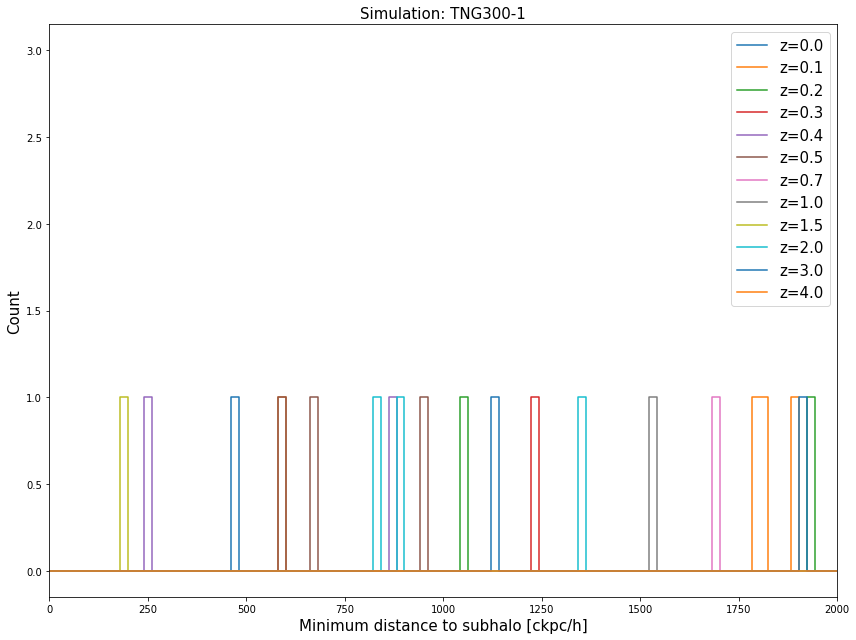

In [156]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_title('Simulation: {0}'.format(sim_to_load),fontsize=15)
ax.set_xlabel('Minimum distance to subhalo [ckpc/h]',fontsize=15)
ax.set_ylabel('Count',fontsize=15)
ax.set_xlim([0,2000])

bin_edges = np.logspace(0,4,num=500) #set bins for histogramming
bin_edges = np.linspace(0,1e4,num=500)

for i in range(len(snap_list)): #loop over snapshots
    snapshot = snap_list[i] #the snapshot
    redshift = snap_z_list[i] #the redshifts
    ifs = impact_factor_dict[str(snapshot)] #get the impact factors
    ifs_flattened = np.concatenate(ifs).ravel() #flatten this array
    print(ifs_flattened)
    counts, bins = np.histogram(ifs_flattened,bins=bin_edges)
    #print(len(counts[1]))
    plt.step(bins[0:-1],counts,label='z={0:.1f}'.format(redshift))
plt.legend(fontsize=15)
plt.savefig('pipe_impact_factors_{0}.png'.format(sim_to_load),format='png')
plt.tight_layout()
plt.show()

# Calculate:
##total DM for a single line of sight, LSS DM values for this line of sight, stats on subhalos crossed by this los

##Also extract LSS cell details

In [157]:
#calculate DMIGM(z) for a single line of sight according to paper

############
#Initialise#
############

x = snap_list

DMIGM_Zhang     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0
DMIGM_Pakmor     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0

DMIGM_Halo_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM
DMIGM_Halo_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only halo portion of DM

DMIGM_Fila_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM
DMIGM_Fila_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only filament portion of DM

DMIGM_Void_Zhang = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM
DMIGM_Void_Pakmor = [[0]*u.pc*u.cm**-3] #set initial condition for only void portion of DM

HaloCells_Zhang = [0.] #initialise arrays to store the number of halo cells for the created LoS
HaloCells_Pakmor = [0.] #initialise arrays to store the number of halo cells for the created LoS

FilaCells_Zhang = [0.] #initialise arrays to store the number of filament cells for the created LoS
FilaCells_Pakmor = [0.] #initialise arrays to store the number of filament cells for the created LoS

VoidCells_Zhang = [0.] #initialise arrays to store the number of void cells for the created LoS
VoidCells_Pakmor = [0.] #initialise arrays to store the number of void cells for the created LoS

num_subhalos = [0.] #initialise array to store the  number of subhalos at each redshift for the created LoS

#####################
#loop over snapshots#
#####################

for i in range(len(x)-1): 
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for this redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id])))
    print(rand_idx_Zhang)
    #get the dDMdz values
    rand_dDMdz_Zhang = dDMdz_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Halo_Zhang = dDMdz_HaloDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Fila_Zhang = dDMdz_FilaDict_Zhang[snap_id][rand_idx_Zhang]
    rand_dDMdz_Void_Zhang = dDMdz_VoidDict_Zhang[snap_id][rand_idx_Zhang]
    #get the cell values
    rand_nHalo_Zhang = halo_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nFila_Zhang = fila_dict_Zhang[snap_id][rand_idx_Zhang]
    rand_nVoid_Zhang = void_dict_Zhang[snap_id][rand_idx_Zhang]

    print('For Snapshot {0}'.format(snap_id))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang))
    print('dDM/dz Zhang values are',rand_dDMdz_Zhang,rand_dDMdz_Halo_Zhang+rand_dDMdz_Fila_Zhang+rand_dDMdz_Void_Zhang)
    print('cell values are',rand_nHalo_Zhang,rand_nFila_Zhang,rand_nVoid_Zhang)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id])))
    print(rand_idx_Pakmor)
    #get the dDMdz values
    rand_dDMdz_Pakmor = dDMdz_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Halo_Pakmor = dDMdz_HaloDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Fila_Pakmor = dDMdz_FilaDict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_dDMdz_Void_Pakmor = dDMdz_VoidDict_Pakmor[snap_id][rand_idx_Pakmor]
    #get the cell values
    rand_nHalo_Pakmor = halo_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nFila_Pakmor = fila_dict_Pakmor[snap_id][rand_idx_Pakmor]
    rand_nVoid_Pakmor = void_dict_Pakmor[snap_id][rand_idx_Pakmor]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor,rand_dDMdz_Halo_Pakmor+rand_dDMdz_Fila_Pakmor+rand_dDMdz_Void_Pakmor)    
    print('cell values are',rand_nHalo_Pakmor,rand_nFila_Pakmor,rand_nVoid_Pakmor)
    
    #############################
    #get the subhalo information#
    #############################
    
    rand_unique_ShIDs = np.array(unique_ShIDs_dict[snap_id][rand_idx_Zhang])
    rand_unique_ShIDs_notNeg1 = rand_unique_ShIDs[np.where(rand_unique_ShIDs!=-1)]
    rand_first_ShIDs = first_ShID_dict[snap_id][rand_idx_Zhang]
    rand_impactFacts = impact_factor_dict[snap_id][rand_idx_Zhang]
    print('unique subhalos are', rand_unique_ShIDs)
    print('ones not -1: {0}'.format(rand_unique_ShIDs_notNeg1))

    
    
    ##############################################################
    #randomly select dDM/dz and LSS cell values for next redshift#
    ##############################################################
    
    #######
    #Zhang#
    #######
    
    #select the pipe
    rand_idx_Zhang_ = np.random.choice(np.arange(len(dDMdz_dict_Zhang[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Zhang_ = dDMdz_dict_Zhang[snap_id_][rand_idx_Zhang_]    
    rand_dDMdz_Halo_Zhang_ = dDMdz_HaloDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Fila_Zhang_ = dDMdz_FilaDict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_dDMdz_Void_Zhang_ = dDMdz_VoidDict_Zhang[snap_id_][rand_idx_Zhang_]
    #get the cell values
    rand_nHalo_Zhang_ = halo_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nFila_Zhang_ = fila_dict_Zhang[snap_id_][rand_idx_Zhang_]
    rand_nVoid_Zhang_ = void_dict_Zhang[snap_id_][rand_idx_Zhang_]
    print('For next redshift ({0}):'.format(snap_id_))
    print('The random Zhang id is {0}'.format(rand_idx_Zhang_))    
    print('Ddm/dz Zhang values are',rand_dDMdz_Zhang_,rand_dDMdz_Halo_Zhang_+rand_dDMdz_Fila_Zhang_+rand_dDMdz_Void_Zhang_)
    print('cell values',rand_nHalo_Zhang_,rand_nFila_Zhang_,rand_nVoid_Zhang_)

    ########
    #Pakmor#
    ########
    
    #select the pipe
    rand_idx_Pakmor_ = np.random.choice(np.arange(len(dDMdz_dict_Pakmor[snap_id_])))   
    #get the dDMdz values
    rand_dDMdz_Pakmor_ = dDMdz_dict_Pakmor[snap_id_][rand_idx_Pakmor_]    
    rand_dDMdz_Halo_Pakmor_ = dDMdz_HaloDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Fila_Pakmor_ = dDMdz_FilaDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_dDMdz_Void_Pakmor_ = dDMdz_VoidDict_Pakmor[snap_id_][rand_idx_Pakmor_]
    #get the cell values
    rand_nHalo_Pakmor_ = halo_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nFila_Pakmor_ = fila_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    rand_nVoid_Pakmor_ = void_dict_Pakmor[snap_id_][rand_idx_Pakmor_]
    print('The random Pakmor id is {0}'.format(rand_idx_Pakmor_))
    print('dDM/dz Pakmor values are',rand_dDMdz_Pakmor_,rand_dDMdz_Halo_Pakmor_+rand_dDMdz_Fila_Pakmor_+rand_dDMdz_Void_Pakmor_)
    print('cell values are',rand_nHalo_Pakmor_,rand_nFila_Pakmor_,rand_nVoid_Pakmor_)
    
    #############################
    #get the subhalo information#
    #############################
    
    rand_unique_ShIDs_ = np.array(unique_ShIDs_dict[snap_id_][rand_idx_Zhang_])
    rand_unique_ShIDs_notNeg1_ = rand_unique_ShIDs_[np.where(rand_unique_ShIDs_!=-1)]
    rand_first_ShIDs_ = first_ShID_dict[snap_id_][rand_idx_Zhang_]
    rand_impactFacts_ = impact_factor_dict[snap_id_][rand_idx_Zhang_]
    print('unique subhalos are', rand_unique_ShIDs_)
    print('ones not -1: {0}'.format(rand_unique_ShIDs_notNeg1_))
    
    ######################
    #create the DM values#
    ######################
    
    nextDM_Zhang     = DMIGM_Zhang[i] + ((0.5*(rand_dDMdz_Zhang+rand_dDMdz_Zhang_)) * (snap_z_ -  snap_z))
    nextDM_Pakmor     = DMIGM_Pakmor[i] + ((0.5*(rand_dDMdz_Pakmor+rand_dDMdz_Pakmor_)) * (snap_z_ -  snap_z))

    nextHaloDM_Zhang = DMIGM_Halo_Zhang[i] + ((0.5*(rand_dDMdz_Halo_Zhang+rand_dDMdz_Halo_Zhang_)) * (snap_z_ -  snap_z))
    nextHaloDM_Pakmor = DMIGM_Halo_Pakmor[i] + ((0.5*(rand_dDMdz_Halo_Pakmor+rand_dDMdz_Halo_Pakmor_)) * (snap_z_ -  snap_z))

    nextFilaDM_Zhang = DMIGM_Fila_Zhang[i] + ((0.5*(rand_dDMdz_Fila_Zhang+rand_dDMdz_Fila_Zhang_)) * (snap_z_ -  snap_z))
    nextFilaDM_Pakmor = DMIGM_Fila_Pakmor[i] + ((0.5*(rand_dDMdz_Fila_Pakmor+rand_dDMdz_Fila_Pakmor_)) * (snap_z_ -  snap_z))

    nextVoidDM_Zhang = DMIGM_Void_Zhang[i] + ((0.5*(rand_dDMdz_Void_Zhang+rand_dDMdz_Void_Zhang_)) * (snap_z_ -  snap_z))
    nextVoidDM_Pakmor = DMIGM_Void_Pakmor[i] + ((0.5*(rand_dDMdz_Void_Pakmor+rand_dDMdz_Void_Pakmor_)) * (snap_z_ -  snap_z))
    
    ################################################################################
    #create the number of LSS cell value by averaging those of the two chosen pipes#
    ################################################################################
    
    nextHalo_Zhang = (0.5*(rand_nHalo_Zhang+rand_nHalo_Zhang_))
    nextHalo_Pakmor = (0.5*(rand_nHalo_Pakmor+rand_nHalo_Pakmor_))

    nextFila_Zhang = (0.5*(rand_nFila_Zhang+rand_nFila_Zhang_))
    nextFila_Pakmor = (0.5*(rand_nFila_Pakmor+rand_nFila_Pakmor_))
    
    nextVoid_Zhang = (0.5*(rand_nVoid_Zhang+rand_nVoid_Zhang_))
    nextVoid_Pakmor = (0.5*(rand_nVoid_Pakmor+rand_nVoid_Pakmor_))
    
    ############################################################################################
    #create the number of subhalos traversed value by averaging those from the two chosen pipes#
    ############################################################################################
    
    next_num_Subhalos = (0.5*(len(rand_unique_ShIDs_notNeg1)+len(rand_unique_ShIDs_notNeg1_)))
    print('average number of non- -1 subhalos: {0}'.format(next_num_Subhalos))
    
    ##################
    #Append to arrays#
    ##################
    
    DMIGM_Zhang.append(nextDM_Zhang)
    DMIGM_Pakmor.append(nextDM_Pakmor)
    
    DMIGM_Halo_Zhang.append(nextHaloDM_Zhang)
    DMIGM_Halo_Pakmor.append(nextHaloDM_Pakmor)

    DMIGM_Fila_Zhang.append(nextFilaDM_Zhang)
    DMIGM_Fila_Pakmor.append(nextFilaDM_Pakmor)

    DMIGM_Void_Zhang.append(nextVoidDM_Zhang)
    DMIGM_Void_Pakmor.append(nextVoidDM_Pakmor)
    
    HaloCells_Zhang.append(nextHalo_Zhang)
    HaloCells_Pakmor.append(nextHalo_Pakmor)

    FilaCells_Zhang.append(nextFila_Zhang)
    FilaCells_Pakmor.append(nextFila_Pakmor)

    VoidCells_Zhang.append(nextVoid_Zhang)
    VoidCells_Pakmor.append(nextVoid_Pakmor)
    
    num_subhalos.append(next_num_Subhalos)
    
#################################################
#create the fractions of LSS cells at each point#
#################################################

fraction_Halo_Zhang = np.array(HaloCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Halo_Pakmor = np.array(HaloCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Fila_Zhang = np.array(FilaCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Fila_Pakmor = np.array(FilaCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

fraction_Void_Zhang = np.array(VoidCells_Zhang)/(np.array(HaloCells_Zhang)+np.array(FilaCells_Zhang)+np.array(VoidCells_Zhang))
fraction_Void_Pakmor = np.array(VoidCells_Pakmor)/(np.array(HaloCells_Pakmor)+np.array(FilaCells_Pakmor)+np.array(VoidCells_Pakmor))

#########################
#Convert to numpy arrays#
#########################

DMIGM_Zhang = np.array(DMIGM_Zhang)
DMIGM_Pakmor = np.array(DMIGM_Pakmor)

DMIGM_Halo_Zhang = np.array(DMIGM_Halo_Zhang)
DMIGM_Halo_Pakmor = np.array(DMIGM_Halo_Pakmor)

DMIGM_Fila_Zhang = np.array(DMIGM_Fila_Zhang)
DMIGM_Fila_Pakmor = np.array(DMIGM_Fila_Pakmor)

DMIGM_Void_Zhang = np.array(DMIGM_Void_Zhang)
DMIGM_Void_Pakmor = np.array(DMIGM_Void_Pakmor)

#################################################################
#Create the total number of subhalos traversed by this sightline#
#################################################################
print('number of subhaloes traversed: {0}'.format(num_subhalos))
tot_subhalos_traversed = np.sum(num_subhalos)
print('total: {0}'.format(tot_subhalos_traversed))

print(' tests')
print(len(x),len(DMIGM_Zhang))
print(HaloCells_Zhang)
print('DM_tests')
print(DMIGM_Zhang,DMIGM_Halo_Zhang+DMIGM_Fila_Zhang+DMIGM_Void_Zhang)
print('fracion tests')
print(fraction_Halo_Zhang)
print(fraction_Fila_Zhang)
print(fraction_Void_Zhang)
print(fraction_Halo_Zhang+fraction_Fila_Zhang+fraction_Void_Zhang)

0
99 91
2.220446049250313e-16 0.09940180263022191
3192
For Snapshot 99
The random Zhang id is 3192
dDM/dz Zhang values are 1019.3349408448315 pc / cm3 1019.3349408448316 pc / cm3
cell values are 3 1867 8130
4978
The random Pakmor id is 4978
dDM/dz Pakmor values are 1017.6565416840942 pc / cm3 1017.6565410636938 pc / cm3
cell values are 8 2435 7557
unique subhalos are [1]
ones not -1: [1]
For next redshift (91):
The random Zhang id is 1334
Ddm/dz Zhang values are 540.0671960750237 pc / cm3 540.067196075024 pc / cm3
cell values 0 1534 8466
The random Pakmor id is 1978
dDM/dz Pakmor values are 547.031376847254 pc / cm3 547.0313766946624 pc / cm3
cell values are 0 1627 8373
unique subhalos are [1]
ones not -1: [1]
average number of non- -1 subhalos: 1.0
1
91 84
0.09940180263022191 0.19728418237600986
2539
For Snapshot 91
The random Zhang id is 2539
dDM/dz Zhang values are 509.563005974846 pc / cm3 509.5630059748461 pc / cm3
cell values are 0 1863 8137
3454
The random Pakmor id is 3454
dDM/

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:230: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:233: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:234: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:236: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in true_divide


# Note: the below code will plot number fractions wrong until the data is fixed

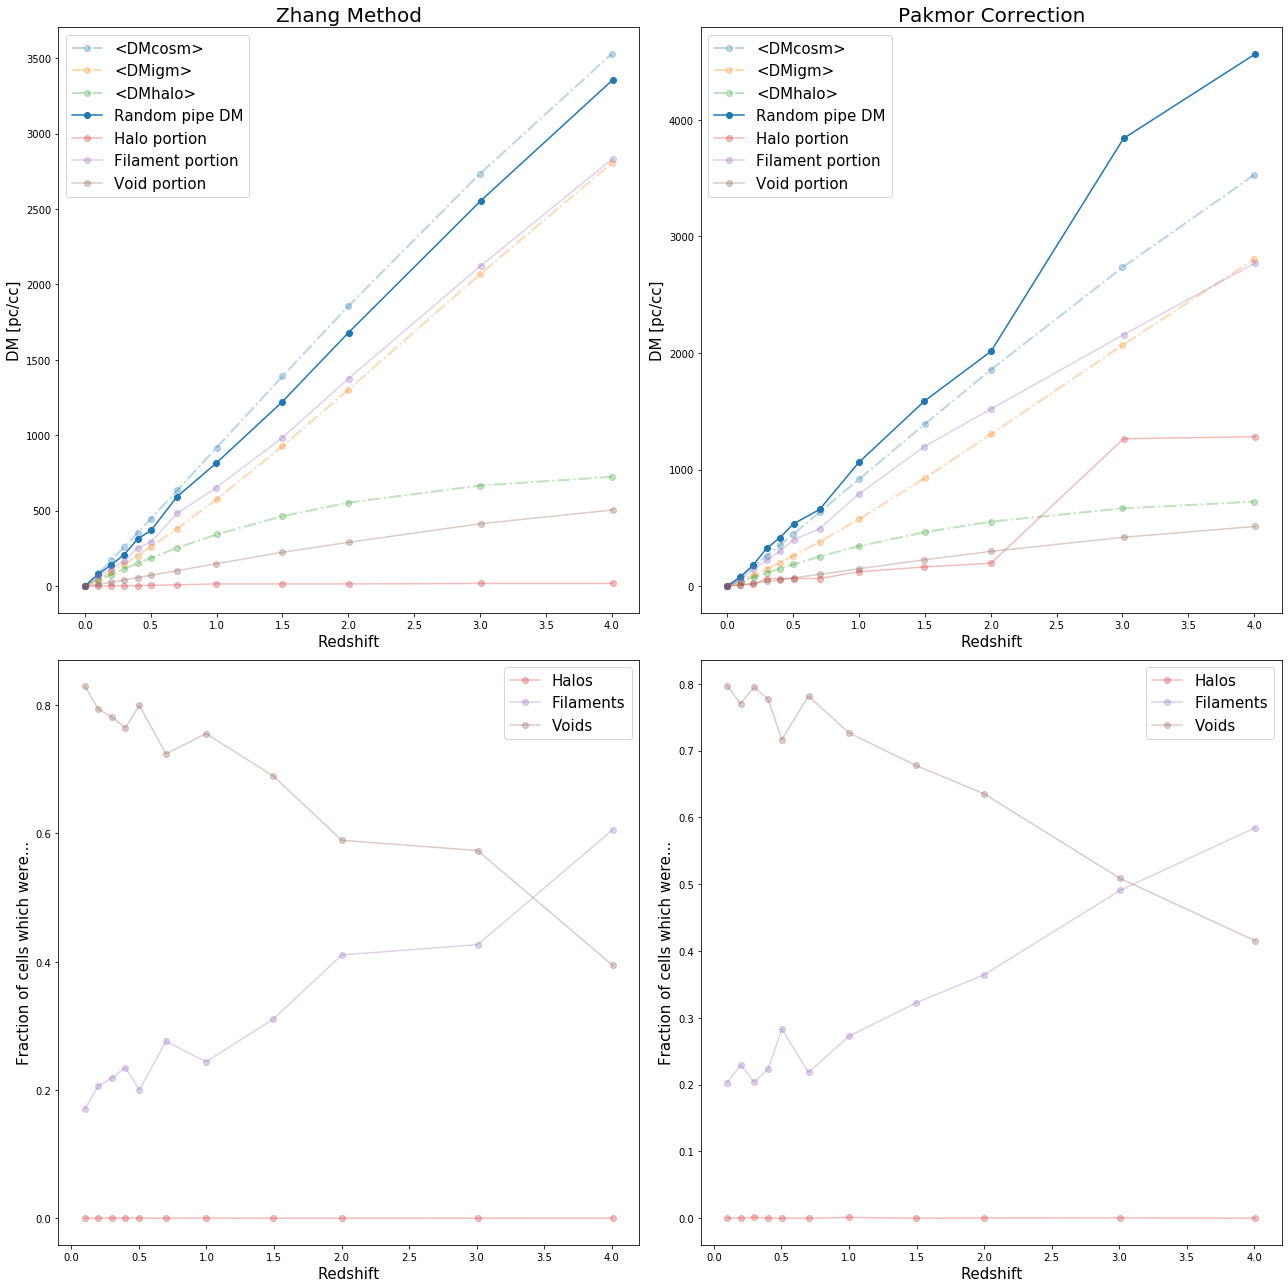

[    nan 0.17005 0.20585 0.2184  0.235   0.20005 0.27585 0.24395 0.3106
 0.4106  0.4266  0.60565] [    nan 0.2031  0.2297  0.20375 0.22275 0.2834  0.21825 0.2721  0.3222
 0.36455 0.49085 0.5846 ]


In [158]:
##########################################
#plot single line of sight for quick test#
##########################################

#################
#initialise plot#
#################
fig = plt.figure(figsize=(18,18))

ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)

#################
#plot the theory#
#################

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

##############
#plot the los#
##############

ax1.plot(snap_z_list,DMIGM_Zhang,marker='o',label='Random pipe DM')
ax1.plot(snap_z_list,DMIGM_Halo_Zhang,marker='o',color='C3',alpha=0.3,label='Halo portion')
ax1.plot(snap_z_list,DMIGM_Fila_Zhang,marker='o',color='C4',alpha=0.3,label='Filament portion')
ax1.plot(snap_z_list,DMIGM_Void_Zhang,marker='o',color='C5',alpha=0.3,label='Void portion')
ax1.legend(fontsize=15)

ax2.plot(snap_z_list,DMIGM_Pakmor,marker='o',label='Random pipe DM')
ax2.plot(snap_z_list,DMIGM_Halo_Pakmor,marker='o',color='C3',alpha=0.3,label='Halo portion')
ax2.plot(snap_z_list,DMIGM_Fila_Pakmor,marker='o',color='C4',alpha=0.3,label='Filament portion')
ax2.plot(snap_z_list,DMIGM_Void_Pakmor,marker='o',color='C5',alpha=0.3,label='Void portion')
ax2.legend(fontsize=15)

################
#plot fractions#
################

ax3.plot(snap_z_list,fraction_Halo_Zhang,marker='o',color='C3',alpha=0.3,label='Halos')
ax3.plot(snap_z_list,fraction_Fila_Zhang,marker='o',color='C4',alpha=0.3,label='Filaments')
ax3.plot(snap_z_list,fraction_Void_Zhang,marker='o',color='C5',alpha=0.3,label='Voids')
ax3.legend(fontsize=15)

ax4.plot(snap_z_list,fraction_Halo_Pakmor,marker='o',color='C3',alpha=0.3,label='Halos')
ax4.plot(snap_z_list,fraction_Fila_Pakmor,marker='o',color='C4',alpha=0.3,label='Filaments')
ax4.plot(snap_z_list,fraction_Void_Pakmor,marker='o',color='C5',alpha=0.3,label='Voids')
ax4.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Single_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()

print(fraction_Fila_Zhang,fraction_Fila_Pakmor)

# Calculate DM for many lines of sight

## creating array of cDM for many sightlines

In [159]:
nlos = 10000000 #number of lines of sight

################################################
#create an array of randomly drawn dDMdz values#
################################################

########################################################################
#array of randomly generated indices to select pipes from each snapshot#
########################################################################

idx_arr_Zhang  = np.array([np.random.choice(np.arange(len(dDMdz_dict_Zhang[str(snap_id)])),size=nlos) for snap_id in snap_list])
idx_arr_Pakmor = np.array([np.random.choice(np.arange(len(dDMdz_dict_Pakmor[str(snap_id)])),size=nlos) for snap_id in snap_list])

#################################
#the dDMdz values of these pipes#
#################################

dDMdz_arr_Zhang  = np.array([dDMdz_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_arr_Pakmor = np.array([dDMdz_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

###################################################
#the halo, filament and void values of these pipes#
###################################################

dDMdz_HaloArr_Zhang = np.array([dDMdz_HaloDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_HaloArr_Pakmor = np.array([dDMdz_HaloDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_FilaArr_Zhang = np.array([dDMdz_FilaDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_FilaArr_Pakmor = np.array([dDMdz_FilaDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

dDMdz_VoidArr_Zhang = np.array([dDMdz_VoidDict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
dDMdz_VoidArr_Pakmor = np.array([dDMdz_VoidDict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

print('check: the difference between the totals and the sum of the structures should be zero')
print(np.sum(dDMdz_arr_Zhang - (dDMdz_HaloArr_Zhang+dDMdz_FilaArr_Zhang+dDMdz_VoidArr_Zhang)))
print(np.sum(dDMdz_arr_Pakmor - (dDMdz_HaloArr_Pakmor+dDMdz_FilaArr_Pakmor+dDMdz_VoidArr_Pakmor)))

#############################
#also extract arrays for LSS#
#############################

#the number of halo cells which made this pipe
los_Halo_arr_Zhang  = np.array([halo_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Halo_arr_Pakmor = np.array([halo_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of filament cells which made this pipe
los_Fila_arr_Zhang  = np.array([fila_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Fila_arr_Pakmor = np.array([fila_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

#the number of void cells which made this pipe
los_Void_arr_Zhang  = np.array([void_dict_Zhang[str(snap_list[snap])][idx_arr_Zhang][snap] for snap in range(len(snap_list))])
los_Void_arr_Pakmor = np.array([void_dict_Pakmor[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])
print('VOID:{0}'.format(los_Void_arr_Pakmor.shape))

##################################
#also extract arrays for subhalos#
##################################

#the unique subhalo ID values traversed by this pipe
los_ShID_arr = np.array([unique_ShIDs_dict[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])
#the impact factors to subhalos traversed by this pipe:
if_arr = np.array([impact_factor_dict[str(snap_list[snap])][idx_arr_Pakmor][snap] for snap in range(len(snap_list))])

######################################################################################################
#calculate the number of impact factors (aka number of non- negative one subhalos traversed) by pipes#
######################################################################################################

n_all_ifs = [] #initialise array to hold if count for every pipe in every snapshot

for i in range(len(if_arr)): #loop over each snapshot
    n_pipe_ifs = [] #initialise array to hold this snapshot's pipes' if counts
    snap_ifs = if_arr[i] #this snapshot's pipes' if values
    
    for j in range(len(snap_ifs)): #loop over this snapshot's pipes
        pipe_ifs = snap_ifs[j] #this pipe's if values
        n_ifs = len(pipe_ifs) #this pipe's if count (aka the number of subhalos traversed by pipe)
        n_pipe_ifs.append(n_ifs) #append if count to list
        
    n_pipe_ifs=np.array(n_pipe_ifs) #convert list of if counts to array
    n_all_ifs.append(n_pipe_ifs) #append this snapshot's if counts to list
n_all_ifs=np.array(n_all_ifs) #convert list of snapshot if counts to array


print('check: impact factors for {0} pipes: {1}'.format(if_arr.shape,if_arr))
print('and check: the corresponding {0} if counts: {1}'.format(n_all_ifs.shape,n_all_ifs))

###########################
#create array of redshifts#
###########################

z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

####################################################
#perform the calculation to get DM at each redshift#
####################################################

DM_arr_Zhang  = (0.5*(dDMdz_arr_Zhang[:,:][0:-1]+dDMdz_arr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total
DM_arr_Pakmor = (0.5*(dDMdz_arr_Pakmor[:,:][0:-1]+dDMdz_arr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #total

DM_HaloArr_Zhang  = (0.5*(dDMdz_HaloArr_Zhang[:,:][0:-1]+dDMdz_HaloArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos
DM_HaloArr_Pakmor = (0.5*(dDMdz_HaloArr_Pakmor[:,:][0:-1]+dDMdz_HaloArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #halos

DM_FilaArr_Zhang  = (0.5*(dDMdz_FilaArr_Zhang[:,:][0:-1]+dDMdz_FilaArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments
DM_FilaArr_Pakmor = (0.5*(dDMdz_FilaArr_Pakmor[:,:][0:-1]+dDMdz_FilaArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #filaments

DM_VoidArr_Zhang  = (0.5*(dDMdz_VoidArr_Zhang[:,:][0:-1]+dDMdz_VoidArr_Zhang[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids
DM_VoidArr_Pakmor = (0.5*(dDMdz_VoidArr_Pakmor[:,:][0:-1]+dDMdz_VoidArr_Pakmor[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None] #voids

######################################################################
#perform the calculation to get the average LSS data at each redshift#
######################################################################

av_Hal_arr_Zhang  = (0.5*(los_Halo_arr_Zhang[:,:][0:-1]+los_Halo_arr_Zhang[:,:][1:]))
av_Hal_arr_Pakmor = (0.5*(los_Halo_arr_Pakmor[:,:][0:-1]+los_Halo_arr_Pakmor[:,:][1:]))

av_Fil_arr_Zhang  = (0.5*(los_Fila_arr_Zhang[:,:][0:-1]+los_Fila_arr_Zhang[:,:][1:]))
av_Fil_arr_Pakmor = (0.5*(los_Fila_arr_Pakmor[:,:][0:-1]+los_Fila_arr_Pakmor[:,:][1:]))

av_Voi_arr_Zhang  = (0.5*(los_Void_arr_Zhang[:,:][0:-1]+los_Void_arr_Zhang[:,:][1:]))
av_Voi_arr_Pakmor = (0.5*(los_Void_arr_Pakmor[:,:][0:-1]+los_Void_arr_Pakmor[:,:][1:]))

print('check: the sum of these should be 10,000 for every pipe at every z\n',
      'Zhang',
       av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang,
       np.mean(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang),
      'Pakmor',
       av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor,
       np.mean(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor))

##################################################################################
#perform calculation to get the average number of impact factors at each redshift#
##################################################################################

av_n_all_ifs  = (0.5*(n_all_ifs[:,:][0:-1]+n_all_ifs[:,:][1:]))
print('check average if shape: {0}'.format(av_n_all_ifs.shape))


##############################################################################
#perform the calculation to turn these into fractions of LSS at each redshift#
##############################################################################

frac_Hal_arr_Zhang  = av_Hal_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Hal_arr_Pakmor = av_Hal_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Fil_arr_Zhang  = av_Fil_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Fil_arr_Pakmor = av_Fil_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

frac_Voi_arr_Zhang  = av_Voi_arr_Zhang/(av_Hal_arr_Zhang+av_Fil_arr_Zhang+av_Voi_arr_Zhang)
frac_Voi_arr_Pakmor = av_Voi_arr_Pakmor/(av_Hal_arr_Pakmor+av_Fil_arr_Pakmor+av_Voi_arr_Pakmor)

print('check: the sum of these {0} should be 1 for every pipe at every z\n'.format(frac_Hal_arr_Zhang.shape),
      'Zhang',
      frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang,
      np.sum((frac_Hal_arr_Zhang+frac_Fil_arr_Zhang+frac_Voi_arr_Zhang),axis=0),
      'Pakmor',
      frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor,
      np.sum((frac_Hal_arr_Pakmor+frac_Fil_arr_Pakmor+frac_Voi_arr_Pakmor),axis=0))

#######################################
#add the initial condition of DM=0@z=0#
#######################################

#DMs
DM_arr_Zhang      = np.insert(DM_arr_Zhang,0,np.zeros(nlos),axis=0)
DM_arr_Pakmor     = np.insert(DM_arr_Pakmor,0,np.zeros(nlos),axis=0)

Hal_DM_arr_Zhang  = np.insert(DM_HaloArr_Zhang,0,np.zeros(nlos),axis=0)
Hal_DM_arr_Pakmor = np.insert(DM_HaloArr_Pakmor,0,np.zeros(nlos),axis=0)

Fil_DM_arr_Zhang  = np.insert(DM_FilaArr_Zhang,0,np.zeros(nlos),axis=0)
Fil_DM_arr_Pakmor = np.insert(DM_FilaArr_Pakmor,0,np.zeros(nlos),axis=0)

Voi_DM_arr_Zhang  = np.insert(DM_VoidArr_Zhang,0,np.zeros(nlos),axis=0)
Voi_DM_arr_Pakmor = np.insert(DM_VoidArr_Pakmor,0,np.zeros(nlos),axis=0)

#number fractions
frac_Hal_arr_Zhang  = np.insert(frac_Hal_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Hal_arr_Pakmor = np.insert(frac_Hal_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Fil_arr_Zhang  = np.insert(frac_Fil_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Fil_arr_Pakmor = np.insert(frac_Fil_arr_Pakmor,0,np.zeros(nlos),axis=0)

frac_Voi_arr_Zhang  = np.insert(frac_Voi_arr_Zhang,0,np.zeros(nlos),axis=0)
frac_Voi_arr_Pakmor = np.insert(frac_Voi_arr_Pakmor,0,np.zeros(nlos),axis=0)

#subhalos traversed by each pipe
av_n_all_ifs        = np.insert(av_n_all_ifs,0,np.zeros(nlos),axis=0)

print('Zhang check: the DM_arr / the sum of the structures should be 1',DM_arr_Zhang/(Hal_DM_arr_Zhang+Fil_DM_arr_Zhang+Voi_DM_arr_Zhang))
print('Pakmor check: the DM_arr / the sum of the structures should be 1',DM_arr_Pakmor/(Hal_DM_arr_Pakmor+Fil_DM_arr_Pakmor+Voi_DM_arr_Pakmor))

##############################################################
#perform the cumulative sum to get the cDM for each light ray#
##############################################################

cDM_arr_Zhang = np.cumsum(DM_arr_Zhang,axis=0) #total
cDM_arr_Pakmor  = np.cumsum(DM_arr_Pakmor,axis=0) #total

Hal_cDM_arr_Zhang  = np.cumsum(Hal_DM_arr_Zhang,axis=0) #halo
Hal_cDM_arr_Pakmor = np.cumsum(Hal_DM_arr_Pakmor,axis=0) #halo

Fil_cDM_arr_Zhang  = np.cumsum(Fil_DM_arr_Zhang,axis=0) #filament
Fil_cDM_arr_Pakmor = np.cumsum(Fil_DM_arr_Pakmor,axis=0) #filament

Voi_cDM_arr_Zhang  = np.cumsum(Voi_DM_arr_Zhang,axis=0) #void
Voi_cDM_arr_Pakmor = np.cumsum(Voi_DM_arr_Pakmor,axis=0) #void

#subhalos traversed by each pipe
cIF_arr = np.cumsum(av_n_all_ifs,axis=0)

print('Zhang check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Zhang/(Hal_cDM_arr_Zhang+Fil_cDM_arr_Zhang+Voi_cDM_arr_Zhang))
print('Pakmor check: the cDM_arr / the sum of the structures should be 1',cDM_arr_Pakmor/(Hal_cDM_arr_Pakmor+Fil_cDM_arr_Pakmor+Voi_cDM_arr_Pakmor))


#print(DM_arr)
#print(cDM_arr)
print(cDM_arr_Zhang.shape)
print(cDM_arr_Pakmor.shape)
print('subhalos traversed shape check: {0}'.format(cIF_arr.shape))

check: the difference between the totals and the sum of the structures should be zero
4.450217261364742e-08 pc / cm3
-450010474.8996864 pc / cm3
VOID:(12, 10000000)
check: impact factors for (12, 10000000, 1) pipes: [[[ 74502.45114503]
  [166250.26616999]
  [139284.86014257]
  ...
  [135538.0247349 ]
  [151645.82663583]
  [ 71510.13335105]]

 [[116031.1336691 ]
  [ 14839.78171886]
  [165359.53480896]
  ...
  [ 84838.29783629]
  [116886.06746622]
  [161330.67214063]]

 [[ 70847.21892553]
  [ 47943.01974583]
  [ 95473.41356633]
  ...
  [ 56787.16590893]
  [105374.19891333]
  [ 48494.53670197]]

 ...

 [[135010.79860549]
  [133471.38423232]
  [141523.95380234]
  ...
  [136926.47750837]
  [138206.52898136]
  [ 32000.67277623]]

 [[130184.0693335 ]
  [143338.36964202]
  [131722.39319499]
  ...
  [ 80805.47687992]
  [ 55509.19794291]
  [ 64842.99507382]]

 [[ 10062.55206005]
  [ 44123.35778282]
  [ 38693.57258281]
  ...
  [ 64495.64938879]
  [ 50114.34800774]
  [ 74561.60277391]]]
and check:

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Zhang check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
Pakmor check: the DM_arr / the sum of the structures should be 1 [[       nan        nan        nan ...        nan        nan        nan]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         0.61279224 1.        ]
 [1.         1.         1.         ... 1.         0.57618532 1.        ]]
Zhang check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1. 

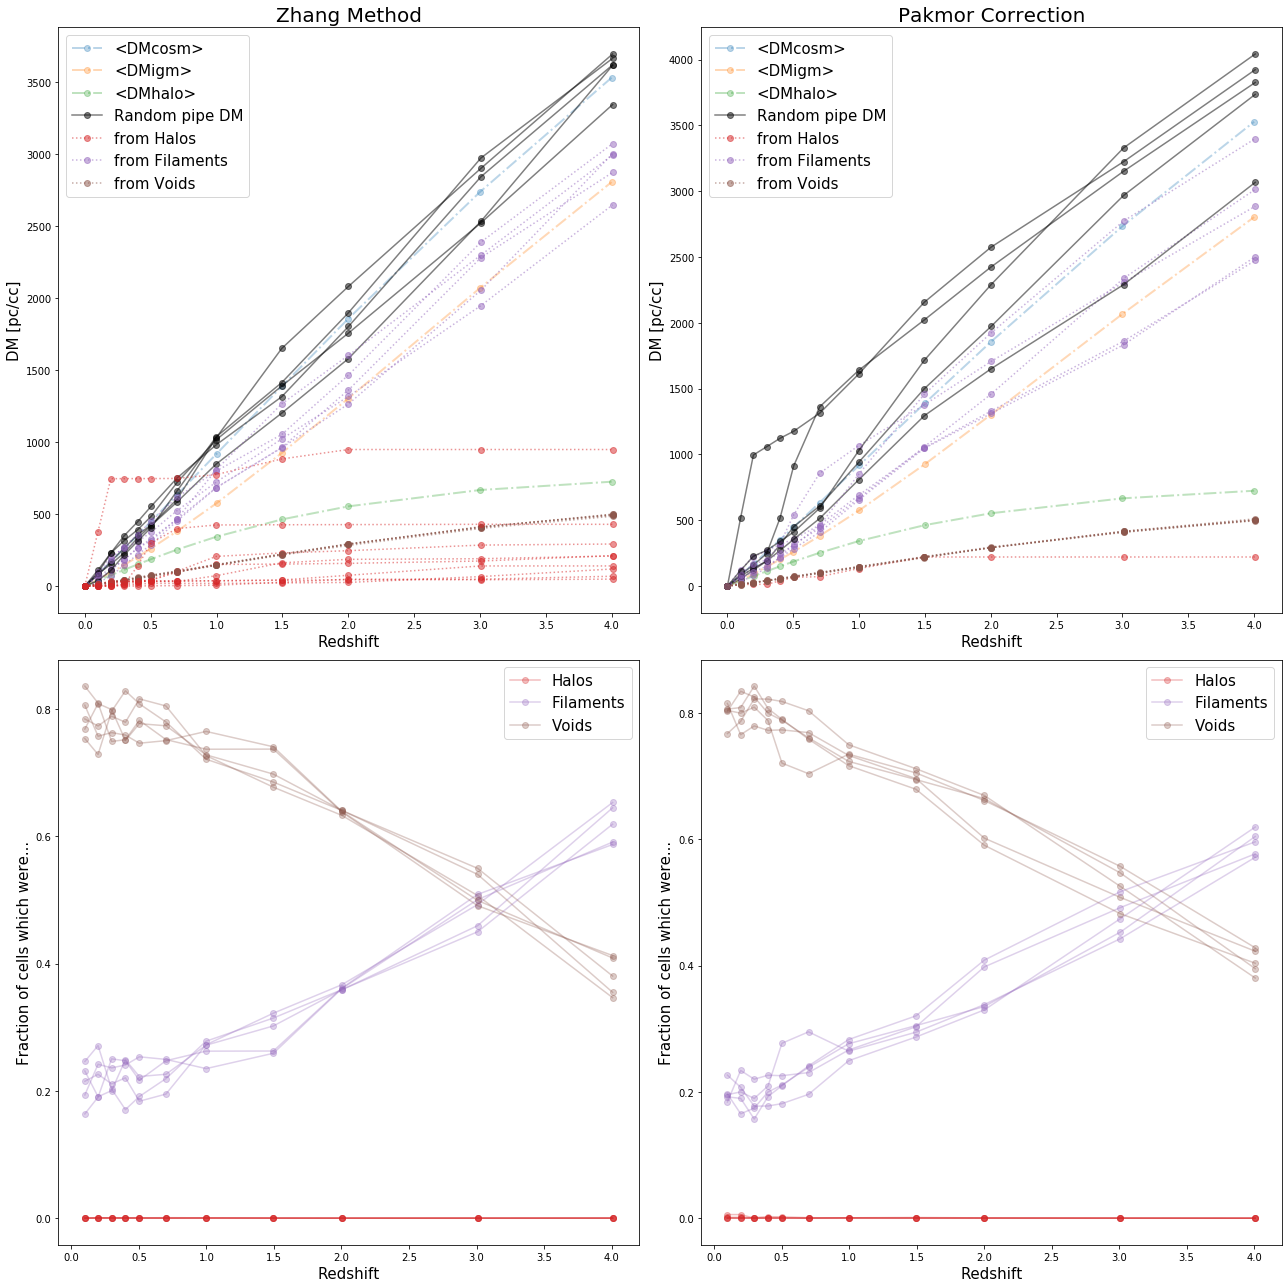

In [160]:
####################
#Initialise figures#
####################

fig = plt.figure(figsize=(18,18))

ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)

#################
#plot the theory#
#################

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

##############
#Plot the DMs#
##############

for i in range(5):
    if i==0:
        ax1.plot(snap_z_list,cDM_arr_Zhang[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax1.plot(snap_z_list,Hal_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax1.plot(snap_z_list,Fil_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax1.plot(snap_z_list,Voi_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax1.plot(snap_z_list,cDM_arr_Zhang[:,i],marker='o',color='k',alpha=0.5)
        ax1.plot(snap_z_list,Hal_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax1.plot(snap_z_list,Fil_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax1.plot(snap_z_list,Voi_cDM_arr_Zhang[:,i],marker='o',ls=':',color='C5',alpha=0.5)
ax1.legend(fontsize=15)

for i in range(5):
    if i==0:
        ax2.plot(snap_z_list,cDM_arr_Pakmor[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax2.plot(snap_z_list,Hal_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax2.plot(snap_z_list,Fil_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax2.plot(snap_z_list,Voi_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax2.plot(snap_z_list,cDM_arr_Pakmor[:,i],marker='o',color='k',alpha=0.5)
        ax1.plot(snap_z_list,Hal_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax2.plot(snap_z_list,Fil_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax2.plot(snap_z_list,Voi_cDM_arr_Pakmor[:,i],marker='o',ls=':',color='C5',alpha=0.5)
ax2.legend(fontsize=15)

###########################
#Plot the number fractions#
###########################

for i in range(5):
    if i==0:
        ax3.plot(snap_z_list[1:],frac_Hal_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax3.plot(snap_z_list[1:],frac_Fil_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax3.plot(snap_z_list[1:],frac_Voi_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax3.plot(snap_z_list[1:],frac_Hal_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax3.plot(snap_z_list[1:],frac_Fil_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax3.plot(snap_z_list[1:],frac_Voi_arr_Zhang[:,i][1:],marker='o',alpha=0.3,color='C5')
        
ax3.legend(fontsize=15)

for i in range(5):
    if i==0:
        ax4.plot(snap_z_list[1:],frac_Hal_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax4.plot(snap_z_list[1:],frac_Fil_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax4.plot(snap_z_list[1:],frac_Voi_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax4.plot(snap_z_list[1:],frac_Hal_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax4.plot(snap_z_list[1:],frac_Fil_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax4.plot(snap_z_list[1:],frac_Voi_arr_Pakmor[:,i][1:],marker='o',alpha=0.3,color='C5')
ax4.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()

## get statistics (DM)

In [161]:
########
#totals#
########

#NOTE: BIG QUESTION ABOUT STDV: Should it be calculated cumulatively?????

mean_cDM_arr_Zhang  = np.mean(cDM_arr_Zhang,axis=1) #mean
mean_cDM_arr_Pakmor = np.mean(cDM_arr_Pakmor,axis=1) #mean

medi_cDM_arr_Zhang  = np.median(cDM_arr_Zhang,axis=1) #median
medi_cDM_arr_Pakmor = np.median(cDM_arr_Pakmor,axis=1) #median

stdv_cDM_arr_Zhang  = np.std(cDM_arr_Zhang,axis=1) #standard deviation
stdv_cDM_arr_Pakmor = np.std(cDM_arr_Pakmor,axis=1) #standard deviation

print('Shapes:', cDM_arr_Pakmor.shape,mean_cDM_arr_Pakmor.shape)



#######
#halos#
#######

mean_Hal_cDM_arr_Zhang  = np.mean(Hal_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Hal_cDM_arr_Pakmor = np.mean(Hal_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Hal_cDM_arr_Zhang  = np.median(Hal_cDM_arr_Zhang,axis=1) #median of DMs
medi_Hal_cDM_arr_Pakmor = np.median(Hal_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Hal_cDM_arr_Zhang  = np.std(Hal_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Hal_cDM_arr_Pakmor = np.std(Hal_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Hal_arr_Zhang  = np.mean(frac_Hal_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Hal_arr_Pakmor = np.mean(frac_Hal_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Hal_arr_Zhang  = np.median(frac_Hal_arr_Zhang,axis=1) #median of number fractions
medi_frac_Hal_arr_Pakmor = np.median(frac_Hal_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Hal_arr_Zhang  = np.std(frac_Hal_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Hal_arr_Pakmor = np.std(frac_Hal_arr_Pakmor,axis=1) #standard deviation of number fractions

###########
#filaments#
###########

mean_Fil_cDM_arr_Zhang  = np.mean(Fil_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Fil_cDM_arr_Pakmor = np.mean(Fil_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Fil_cDM_arr_Zhang  = np.median(Fil_cDM_arr_Zhang,axis=1) #median of DMs
medi_Fil_cDM_arr_Pakmor = np.median(Fil_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Fil_cDM_arr_Zhang  = np.std(Fil_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Fil_cDM_arr_Pakmor = np.std(Fil_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Fil_arr_Zhang  = np.mean(frac_Fil_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Fil_arr_Pakmor = np.mean(frac_Fil_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Fil_arr_Zhang  = np.median(frac_Fil_arr_Zhang,axis=1) #median of number fractions
medi_frac_Fil_arr_Pakmor = np.median(frac_Fil_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Fil_arr_Zhang  = np.std(frac_Fil_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Fil_arr_Pakmor = np.std(frac_Fil_arr_Pakmor,axis=1) #standard deviation of number fractions

#######
#voids#
#######

mean_Voi_cDM_arr_Zhang  = np.mean(Voi_cDM_arr_Zhang,axis=1) #mean of DMs
mean_Voi_cDM_arr_Pakmor = np.mean(Voi_cDM_arr_Pakmor,axis=1) #mean of DMs

medi_Voi_cDM_arr_Zhang  = np.median(Voi_cDM_arr_Zhang,axis=1) #median of DMs
medi_Voi_cDM_arr_Pakmor = np.median(Voi_cDM_arr_Pakmor,axis=1) #median of DMs

stdv_Voi_cDM_arr_Zhang  = np.std(Voi_cDM_arr_Zhang,axis=1) #standard deviation of DMs
stdv_Voi_cDM_arr_Pakmor = np.std(Voi_cDM_arr_Pakmor,axis=1) #standard deviation of DMs

mean_frac_Voi_arr_Zhang = np.mean(frac_Voi_arr_Zhang,axis=1) #mean of number fractions
mean_frac_Voi_arr_Pakmor = np.mean(frac_Voi_arr_Pakmor,axis=1) #mean of number fractions

medi_frac_Voi_arr_Zhang = np.median(frac_Voi_arr_Zhang,axis=1) #median of number fractions
medi_frac_Voi_arr_Pakmor = np.median(frac_Voi_arr_Pakmor,axis=1) #median of number fractions

stdv_frac_Voi_arr_Zhang = np.std(frac_Voi_arr_Zhang,axis=1) #standard deviation of number fractions
stdv_frac_Voi_arr_Pakmor = np.std(frac_Voi_arr_Pakmor,axis=1) #standard deviation of number fractions



##############
#DM Fractions#
##############

frac_cDM_Hal = Hal_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Halos
frac_cDM_Fil = Fil_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Filaments
frac_cDM_Voi = Voi_cDM_arr_Pakmor/cDM_arr_Pakmor # fraction of DM from Voids
print('Check: sum of fractions should equal 1: {0}'.format(frac_cDM_Hal+frac_cDM_Fil+frac_cDM_Voi))


#stats of these DM fractions
mean_frac_cDM_Hal = np.mean(frac_cDM_Hal,axis=1)   #means
mean_frac_cDM_Fil = np.mean(frac_cDM_Fil,axis=1)   #means
mean_frac_cDM_Voi = np.mean(frac_cDM_Voi,axis=1)   #means
medi_frac_cDM_Hal = np.median(frac_cDM_Hal,axis=1) #medians
medi_frac_cDM_Fil = np.median(frac_cDM_Fil,axis=1) #medians
medi_frac_cDM_Voi = np.median(frac_cDM_Voi,axis=1) #medians
stdv_frac_cDM_Hal = np.std(frac_cDM_Hal,axis=1)    #standard deviations
stdv_frac_cDM_Fil = np.std(frac_cDM_Fil,axis=1)    #standard deviations
stdv_frac_cDM_Voi = np.std(frac_cDM_Voi,axis=1)    #standard deviations



print('Mean cDM: ',mean_cDM_arr_Zhang,mean_cDM_arr_Pakmor)
print('Median cDM: ',medi_cDM_arr_Zhang,medi_cDM_arr_Pakmor)
print('Standard deviation of cDM: ',stdv_cDM_arr_Zhang, stdv_cDM_arr_Pakmor)


Shapes: (12, 10000000) (12,)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Check: sum of fractions should equal 1: [[       nan        nan        nan ...        nan        nan        nan]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.26117207 1.        ]
 [1.         1.         1.         ... 1.         1.38489983 1.        ]]
Mean cDM:  [   0.           92.57817134  188.07250121  288.83808303  393.48959511
  500.76196936  708.45962542 1021.44457474 1528.68637324 2015.96837807
 2895.45434778 3680.80622897] pc / cm3 [   0.           92.60804389  188.1361178   288.68512846  393.07098259
  500.35076144  708.12816361 1020.66718886 1525.85759386 2011.35150015
 2889.49266759 3674.06789559] pc / cm3
Median cDM:  [   0.           77.43454928  162.93094127  256.98110825  356.57191507
  460.17564335  661.13957035  961.28199832 1453.03772131 19

## get statistics (number of subhalos)

In [162]:
#averages

mean_cIF_arr  = np.mean(cIF_arr,axis=1) #mean

medi_cIF_arr  = np.median(cIF_arr,axis=1) #median

stdv_cIF_arr  = np.std(cIF_arr,axis=1) #standard deviation (should it be calculated cumulatively???)

print('Mean number of halos traversed by pipes: {0}'.format(mean_cIF_arr))
print('Median number of halos traversed by pipes: {0}'.format(medi_cIF_arr))
print('Stdv of number of halos traversed by pipes: {0}'.format(stdv_cIF_arr))

Mean number of halos traversed by pipes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Median number of halos traversed by pipes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
Stdv of number of halos traversed by pipes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


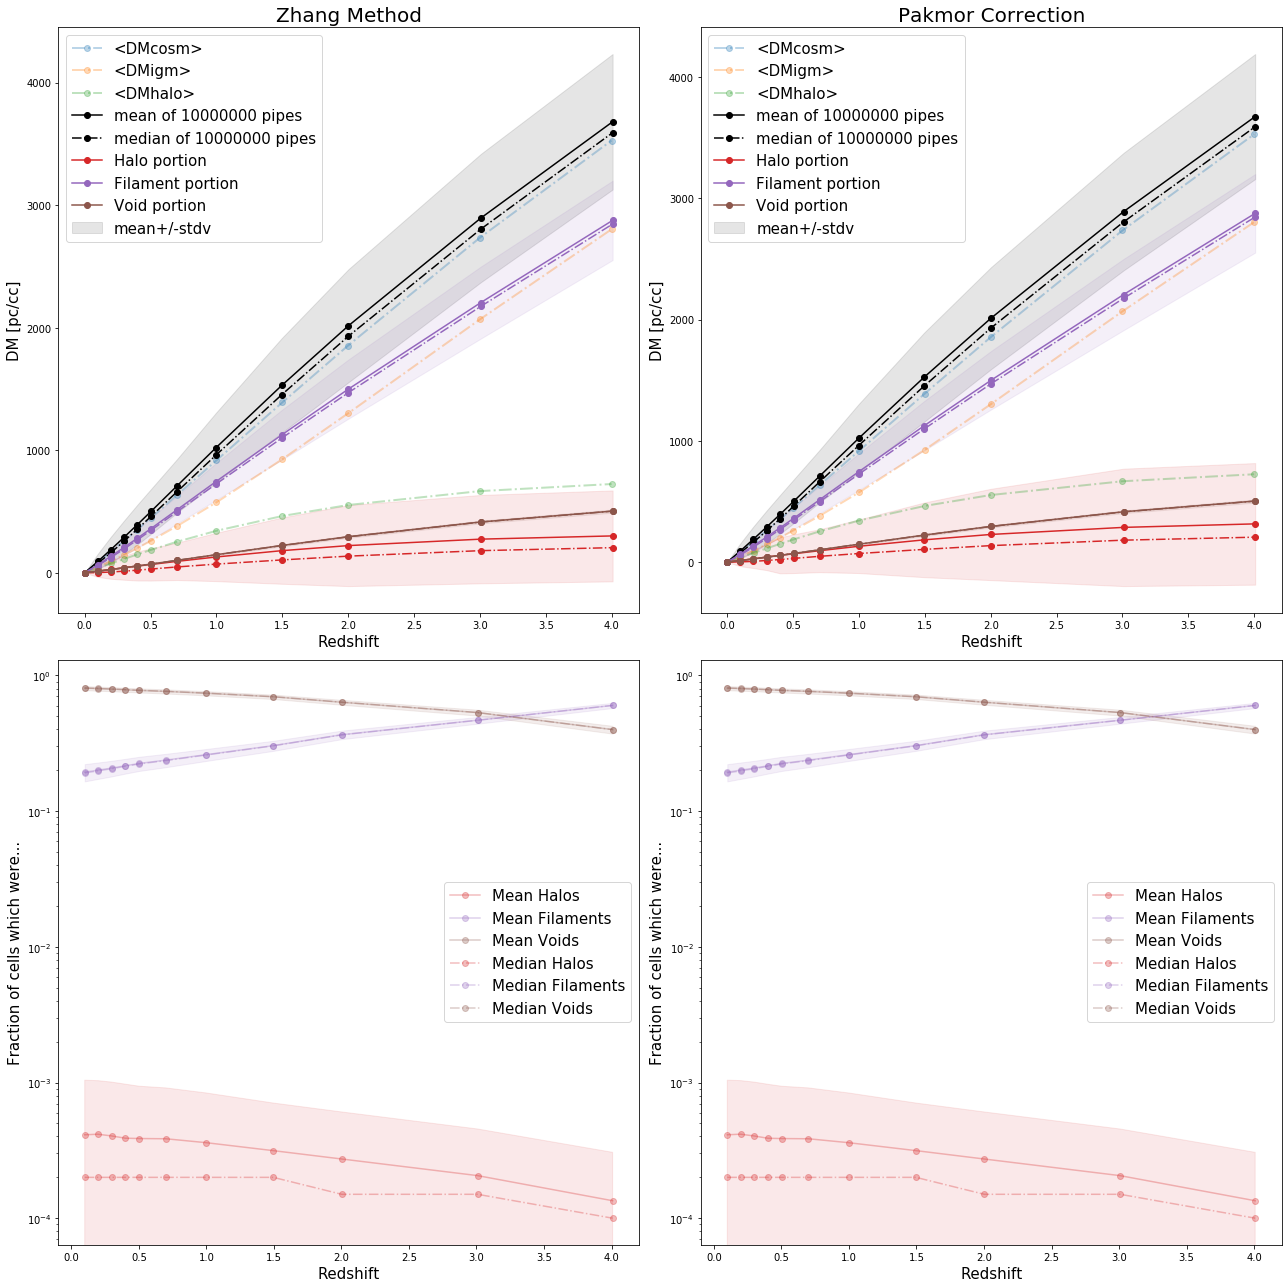

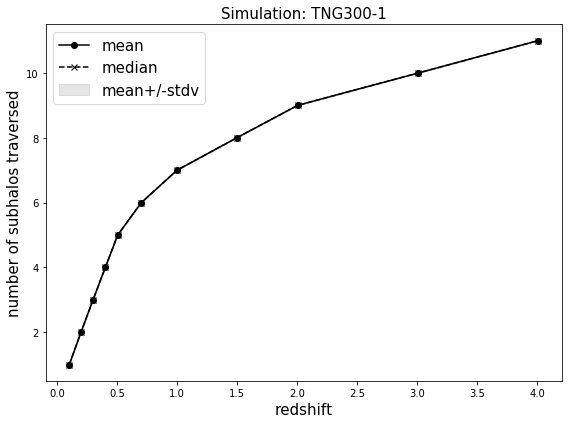

In [163]:
##################
#initialise plots#
##################

fig = plt.figure(figsize=(18,18))
ax1 = fig.add_subplot(221)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM [pc/cc]',fontsize=15)

ax2 = fig.add_subplot(222)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM [pc/cc]',fontsize=15)

ax3 = fig.add_subplot(223)
ax3.set_xlabel('Redshift',fontsize=15)
ax3.set_ylabel('Fraction of cells which were...',fontsize=15)
ax3.set_yscale('log')

ax4 = fig.add_subplot(224)
ax4.set_xlabel('Redshift',fontsize=15)
ax4.set_ylabel('Fraction of cells which were...',fontsize=15)
ax4.set_yscale('log')

#############
#Plot theory#
#############

ax1.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax1.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax1.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax1.legend(fontsize=15)


ax2.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax2.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax2.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax1.legend(fontsize=15)

##########
#plot DMs#
##########

#zhang

ax1.plot(snap_z_list,mean_cDM_arr_Zhang,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr_Zhang.shape[1]))
ax1.plot(snap_z_list,medi_cDM_arr_Zhang,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr_Zhang.shape[1]))
ax1.fill_between(snap_z_list,mean_cDM_arr_Zhang+stdv_cDM_arr_Zhang,mean_cDM_arr_Zhang-stdv_cDM_arr_Zhang,alpha=0.1,color='k',label='mean+/-stdv')

ax1.plot(snap_z_list,mean_Hal_cDM_arr_Zhang,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax1.plot(snap_z_list,medi_Hal_cDM_arr_Zhang,marker='o',color='C3',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Hal_cDM_arr_Zhang+stdv_Hal_cDM_arr_Zhang,mean_Hal_cDM_arr_Zhang-stdv_Hal_cDM_arr_Zhang,alpha=0.1,color='C3')

ax1.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax1.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Fil_cDM_arr_Zhang+stdv_Fil_cDM_arr_Zhang,mean_Fil_cDM_arr_Zhang-stdv_Fil_cDM_arr_Zhang,alpha=0.1,color='C4')

ax1.plot(snap_z_list,mean_Voi_cDM_arr_Zhang,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax1.plot(snap_z_list,medi_Voi_cDM_arr_Zhang,marker='o',color='C5',alpha=1,ls='-.')
ax1.fill_between(snap_z_list,mean_Voi_cDM_arr_Zhang+stdv_Voi_cDM_arr_Zhang,mean_Voi_cDM_arr_Zhang-stdv_Voi_cDM_arr_Zhang,alpha=0.1,color='C5')

ax1.legend(fontsize=15)

#pakmor

ax2.plot(snap_z_list,mean_cDM_arr_Pakmor,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr_Pakmor.shape[1]))
ax2.plot(snap_z_list,medi_cDM_arr_Pakmor,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr_Pakmor.shape[1]))
ax2.fill_between(snap_z_list,mean_cDM_arr_Pakmor+stdv_cDM_arr_Pakmor,mean_cDM_arr_Pakmor-stdv_cDM_arr_Pakmor,alpha=0.1,color='k',label='mean+/-stdv')

ax2.plot(snap_z_list,mean_Hal_cDM_arr_Pakmor,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax2.plot(snap_z_list,medi_Hal_cDM_arr_Pakmor,marker='o',color='C3',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor,mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor,alpha=0.1,color='C3')

ax2.plot(snap_z_list,mean_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax2.plot(snap_z_list,medi_Fil_cDM_arr_Zhang,marker='o',color='C4',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Fil_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor,mean_Fil_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor,alpha=0.1,color='C4')

ax2.plot(snap_z_list,mean_Voi_cDM_arr_Pakmor,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax2.plot(snap_z_list,medi_Voi_cDM_arr_Pakmor,marker='o',color='C5',alpha=1,ls='-.')
ax2.fill_between(snap_z_list,mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor,mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor,alpha=0.1,color='C5')

ax2.legend(fontsize=15)

#######################
#plot number fractions#
#######################

#zhang

ax3.plot(snap_z_list[1:],mean_frac_Hal_arr_Zhang[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax3.plot(snap_z_list[1:],mean_frac_Fil_arr_Zhang[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax3.plot(snap_z_list[1:],mean_frac_Voi_arr_Zhang[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax3.plot(snap_z_list[1:],medi_frac_Hal_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax3.plot(snap_z_list[1:],medi_frac_Fil_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax3.plot(snap_z_list[1:],medi_frac_Voi_arr_Zhang[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax3.fill_between(snap_z_list[1:],mean_frac_Hal_arr_Zhang[1:]+stdv_frac_Hal_arr_Zhang[1:],mean_frac_Hal_arr_Zhang[1:]-stdv_frac_Hal_arr_Zhang[1:],alpha=0.1,color='C3')
ax3.fill_between(snap_z_list[1:],mean_frac_Fil_arr_Zhang[1:]+stdv_frac_Fil_arr_Zhang[1:],mean_frac_Fil_arr_Zhang[1:]-stdv_frac_Fil_arr_Zhang[1:],alpha=0.1,color='C4')
ax3.fill_between(snap_z_list[1:],mean_frac_Voi_arr_Zhang[1:]+stdv_frac_Voi_arr_Zhang[1:],mean_frac_Voi_arr_Zhang[1:]-stdv_frac_Voi_arr_Zhang[1:],alpha=0.1,color='C5')

ax3.legend(fontsize=15)


#pakmor

ax4.plot(snap_z_list[1:],mean_frac_Hal_arr_Pakmor[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax4.plot(snap_z_list[1:],mean_frac_Fil_arr_Pakmor[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax4.plot(snap_z_list[1:],mean_frac_Voi_arr_Pakmor[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax4.plot(snap_z_list[1:],medi_frac_Hal_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax4.plot(snap_z_list[1:],medi_frac_Fil_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax4.plot(snap_z_list[1:],medi_frac_Voi_arr_Pakmor[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax4.fill_between(snap_z_list[1:],mean_frac_Hal_arr_Pakmor[1:]+stdv_frac_Hal_arr_Pakmor[1:],mean_frac_Hal_arr_Pakmor[1:]-stdv_frac_Hal_arr_Pakmor[1:],alpha=0.1,color='C3')
ax4.fill_between(snap_z_list[1:],mean_frac_Fil_arr_Pakmor[1:]+stdv_frac_Fil_arr_Pakmor[1:],mean_frac_Fil_arr_Pakmor[1:]-stdv_frac_Fil_arr_Pakmor[1:],alpha=0.1,color='C4')
ax4.fill_between(snap_z_list[1:],mean_frac_Voi_arr_Pakmor[1:]+stdv_frac_Voi_arr_Pakmor[1:],mean_frac_Voi_arr_Pakmor[1:]-stdv_frac_Voi_arr_Pakmor[1:],alpha=0.1,color='C5')

ax4.legend(fontsize=15)



plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics.png'.format(sim_to_load),format='png')
plt.show()


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.set_title('Simulation: {0}'.format(sim_to_load),fontsize=15)
ax.set_xlabel('redshift',fontsize=15)
ax.set_ylabel('number of subhalos traversed',fontsize=15)

ax.plot(snap_z_list[1:],mean_cIF_arr[1:],marker='o',color='k',ls='-',label='mean')
ax.plot(snap_z_list[1:],medi_cIF_arr[1:],marker='x',color='k',ls='--',label='median')
ax.fill_between(snap_z_list[1:],mean_cIF_arr[1:]+stdv_cIF_arr[1:],mean_cIF_arr[1:]-stdv_cIF_arr[1:],alpha=0.1,color='k',label='mean+/-stdv')

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_IF_Statistics.png'.format(sim_to_load),format='png')
plt.show()

# Plot cumulative DM fraction a bit like in the Aghanim presentation

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


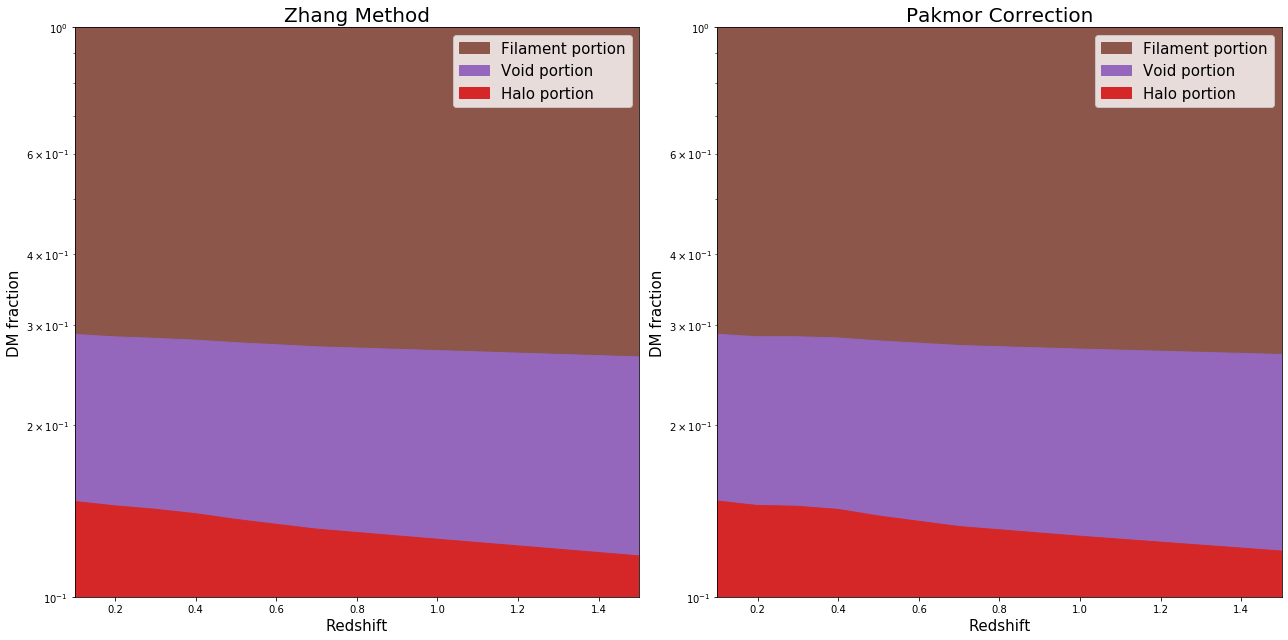

In [164]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(18,9))

ax1 = fig.add_subplot(121)
ax1.set_title('Zhang Method',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM fraction',fontsize=15)
ax1.set_yscale('log')
ax1.set_xlim([0.1,1.5])
ax1.set_ylim([1e-1,1.])

ax2 = fig.add_subplot(122)
ax2.set_title('Pakmor Correction',fontsize=20)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('DM fraction',fontsize=15)
ax2.set_yscale('log')
ax2.set_xlim([0.1,1.5])
ax2.set_ylim([1e-1,1.])

######
#plot#
######

ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Zhang+mean_Voi_cDM_arr_Zhang+mean_Fil_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:]),color='C5',alpha=1,ls='-',label='Filament portion')
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Zhang+mean_Voi_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:]),color='C4',alpha=1,ls='-',label='Void portion')
ax1.fill_between(snap_z_list,(mean_Hal_cDM_arr_Zhang)/mean_cDM_arr_Zhang[:],color='C3',alpha=1,ls='-',label='Halo portion')
ax1.legend(fontsize=15)

ax2.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+mean_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C5',alpha=1,ls='-',label='Filament portion')
ax2.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C4',alpha=1,ls='-',label='Void portion')
ax2.fill_between(snap_z_list,(mean_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],color='C3',alpha=1,ls='-',label='Halo portion')
ax2.legend(fontsize=15)

plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2.png'.format(sim_to_load),format='png')
plt.show()

# Copy of the above but only the Pakmor correction for the Fachbeireit

[  0.          47.63663362  76.17100041 107.59616344 148.53038879
 159.50950196 176.68176943 220.52455416 307.82508476 376.6119825
 484.14103623 501.42692337] pc / cm3 [   0.           92.60804389  188.1361178   288.68512846  393.07098259
  500.35076144  708.12816361 1020.66718886 1525.85759386 2011.35150015
 2889.49266759 3674.06789559] pc / cm3 [       nan 0.5143898  0.40487176 0.37271114 0.37787167 0.31879536
 0.24950536 0.21605922 0.20173907 0.18724325 0.16755226 0.13647732]


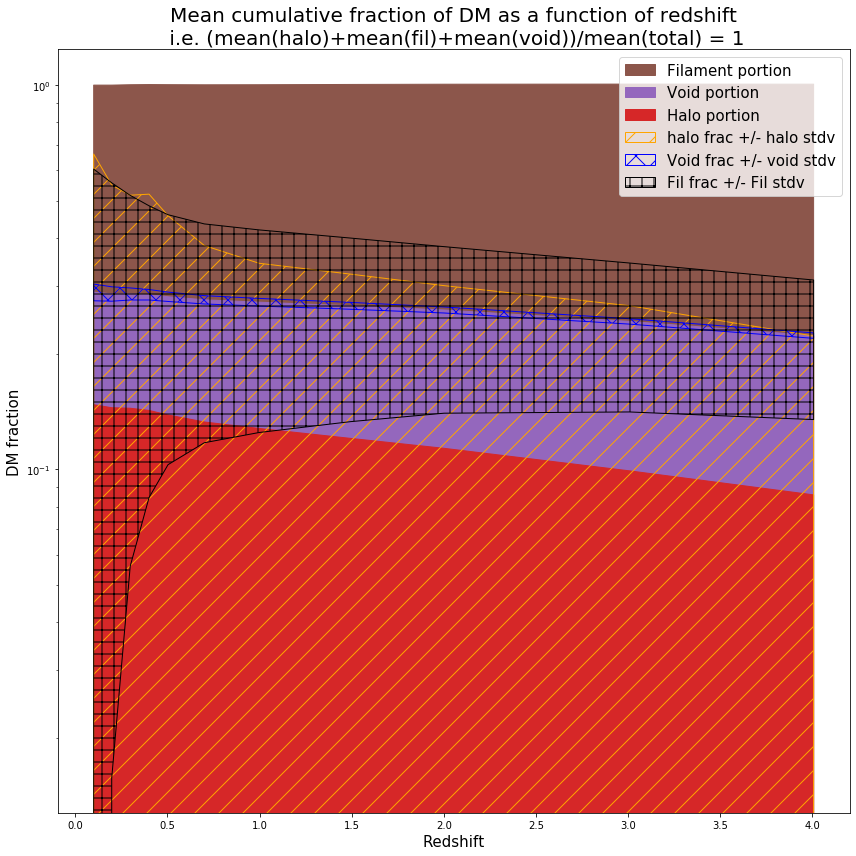

In [165]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(12,12))



ax1 = fig.add_subplot(111)
ax1.set_title('Mean cumulative fraction of DM as a function of redshift\n i.e. (mean(halo)+mean(fil)+mean(void))/mean(total) = 1',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=15)
ax1.set_ylabel('DM fraction',fontsize=15)
ax1.set_yscale('log')
#ax1.set_xlim([0.1,1.5])
#ax1.set_ylim([1e-1,1.])

######
#plot#
######

#DM fraction in halos

#fill plot (i.e. the block colour is DM from halos)
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+mean_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C5',alpha=1,ls='-',label='Filament portion')


#line
#ax1.plot(snap_z_list,mean_Hal_cDM_arr_Pakmor/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='mean halo fraction')
#plus halo stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac + halo stdv')
#minus halo stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac - halo stdv')

#DM fraction in halos plus voids

#fill plot (i.e. the block colour is DM from voids)
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),color='C4',alpha=1,ls='-',label='Void portion')
#line
#ax1.plot(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),marker='o',color='k',alpha=1,ls='--',label='mean halo fraction + mean void fraction')
#plus void stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac + void frac + void stdv')
#minus void stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac + void frac - void stdv')



#DM fraction in halos plus filaments plus voids

#fill plot (i.e. the block colour is the DM from filaments)
ax1.fill_between(snap_z_list,(mean_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],color='C3',alpha=1,ls='-',label='Halo portion')
#note: the line for this frac is actually defined by the same line as the halo+void frac
#plus fil stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac + fil frac + fil stdv')
#minus fil stdv
#ax1.plot(snap_z_list,(mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:],marker='o',color='k',alpha=1,ls='-',label='halo frac + fil frac - fil stdv')


#fill based on halos
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+stdv_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),((mean_Hal_cDM_arr_Pakmor-stdv_Hal_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),facecolor="none", hatch="/",edgecolor="orange",linewidth=1,label='halo frac +/- halo stdv')
#fill based on voids:
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+stdv_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor-stdv_Voi_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),facecolor="none", hatch="X",edgecolor="blue",linewidth=1,label='Void frac +/- void stdv')
#fill based on filaments
ax1.fill_between(snap_z_list,((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor+stdv_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),((mean_Hal_cDM_arr_Pakmor+mean_Voi_cDM_arr_Pakmor-stdv_Fil_cDM_arr_Pakmor)/mean_cDM_arr_Pakmor[:]),facecolor="none", hatch="+",edgecolor="k",linewidth=1,label='Fil frac +/- Fil stdv')

print(stdv_Hal_cDM_arr_Pakmor,mean_cDM_arr_Pakmor[:],stdv_Hal_cDM_arr_Pakmor/mean_cDM_arr_Pakmor[:])

ax1.legend(fontsize=15)


plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2_Fach.png'.format(sim_to_load),format='png')
plt.show()

# Version of this plot with statistics on fractions

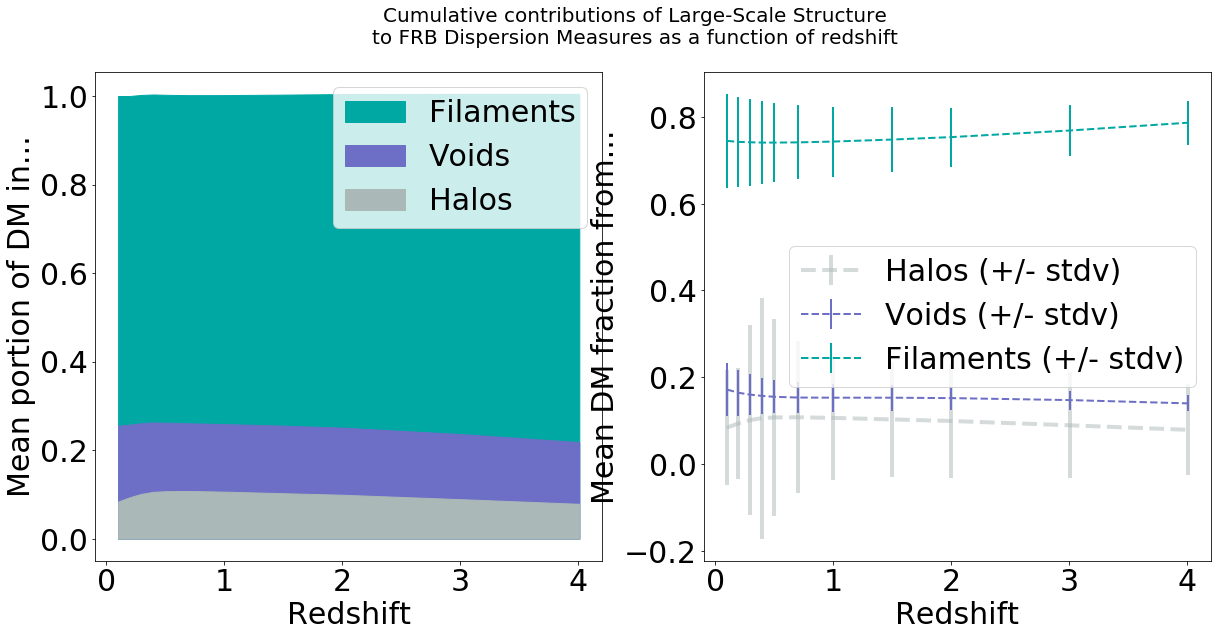

[       nan 1.00513389 1.00511845 1.00494781 1.00474409 1.00458308
 1.00417358 1.0033777  1.00254568 1.00193044 1.00131758 1.00079771]


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide


In [166]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(20,9))

plt.suptitle('Cumulative contributions of Large-Scale Structure\nto FRB Dispersion Measures as a function of redshift',fontsize=20)


ax1 = fig.add_subplot(121)
ax1.set_xlabel('Redshift',fontsize=30)
ax1.set_ylabel('Mean portion of DM in...',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.set_yscale('log')

#filled plots
#ax1.fill_between(snap_z_list,mean_frac_cDM_Fil+mean_frac_cDM_Voi+mean_frac_cDM_Hal,color='C5',alpha=1,ls='-',label='Filaments')
ax1.fill_between(snap_z_list,mean_frac_cDM_Fil+mean_frac_cDM_Voi+mean_frac_cDM_Hal,color='#00a8a4',alpha=1,ls='-',label='Filaments')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Voi+mean_frac_cDM_Hal,color='C4',alpha=1,ls='-',label='Voids')
ax1.fill_between(snap_z_list,mean_frac_cDM_Voi+mean_frac_cDM_Hal,color='#6d6fc7',alpha=1,ls='-',label='Voids')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal,color='C3',alpha=1,ls='-',label='Halos')
ax1.fill_between(snap_z_list,mean_frac_cDM_Hal,color='#aab8b7',alpha=1,ls='-',label='Halos')


#hatched statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,edgecolor=lighten_color('C3',1.2),facecolor='none',hatch="/",alpha=0.7,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,facecolor="none", hatch="x",edgecolor=lighten_color("C4",1.2),alpha=0.7,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,facecolor="none", hatch="+",edgecolor=lighten_color("C5",1.2),alpha=0.7,linewidth=1,label='Stdv around filament frac')

#line statistics
#ax1.errorbar(snap_z_list,mean_frac_cDM_Hal,stdv_frac_cDM_Hal,linewidth=4,color=lighten_color('C3',1.2),ls='--',label='stdv around halo frac')
#ax1.errorbar(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi,stdv_frac_cDM_Fil,linewidth=4,color=lighten_color('C5',1.2),ls='--',label='stdv around fil frac')
#ax1.errorbar(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi,stdv_frac_cDM_Voi,linewidth=4,color=lighten_color('C4',1.2),ls='--',label='stdv around void frac')

#filled statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,color=lighten_color('C3',1.2),alpha=.2,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,color=lighten_color("C4",1.2),alpha=.2,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,color=lighten_color("C5",1.2),alpha=.2,linewidth=1,label='Stdv around filament frac')

#filled and hatched statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,edgecolor=lighten_color('C3',1.2),facecolor=lighten_color('C3',1.2),hatch="/",alpha=0.2,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,facecolor=lighten_color("C4",1.2), hatch="x",edgecolor=lighten_color("C4",1.2),alpha=0.2,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,facecolor=lighten_color("C5",1.2), hatch="+",edgecolor=lighten_color("C5",1.2),alpha=0.2,linewidth=1,label='Stdv around filament frac')




ax1.legend(fontsize=30)

ax1 = fig.add_subplot(122)
#ax1.set_title('Fractions with errors',fontsize=20)
ax1.set_xlabel('Redshift',fontsize=30)
ax1.set_ylabel('Mean DM fraction from...',fontsize=30)
ax1.tick_params(axis='both', which='major', labelsize=30)

#ax1.set_yscale('log')

#filled plots

#hatched statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,edgecolor=lighten_color('C3',1.2),facecolor='none',hatch="/",alpha=0.7,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,facecolor="none", hatch="x",edgecolor=lighten_color("C4",1.2),alpha=0.7,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,facecolor="none", hatch="+",edgecolor=lighten_color("C5",1.2),alpha=0.7,linewidth=1,label='Stdv around filament frac')

#line statistics
#ax1.errorbar(snap_z_list,mean_frac_cDM_Hal,stdv_frac_cDM_Hal,linewidth=4,color=lighten_color('C3',1.),ls='--',label='Halos (+/- stdv)',alpha=0.5)
ax1.errorbar(snap_z_list,mean_frac_cDM_Hal,stdv_frac_cDM_Hal,linewidth=4,color=lighten_color('#aab8b7',1.),ls='--',label='Halos (+/- stdv)',alpha=0.5)
#ax1.errorbar(snap_z_list,mean_frac_cDM_Voi,stdv_frac_cDM_Voi,linewidth=2,color=lighten_color('C4',1.),ls='--',label='Voids (+/- stdv)')
ax1.errorbar(snap_z_list,mean_frac_cDM_Voi,stdv_frac_cDM_Voi,linewidth=2,color=lighten_color('#6d6fc7',1.),ls='--',label='Voids (+/- stdv)')
#ax1.errorbar(snap_z_list,mean_frac_cDM_Fil,stdv_frac_cDM_Fil,linewidth=2,color=lighten_color('C5',1.),ls='--',label='Filaments (+/- stdv)')
ax1.errorbar(snap_z_list,mean_frac_cDM_Fil,stdv_frac_cDM_Fil,linewidth=2,color=lighten_color('#00a8a4',1.),ls='--',label='Filaments (+/- stdv)')

#filled statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,color=lighten_color('C3',1.2),alpha=.2,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,color=lighten_color("C4",1.2),alpha=.2,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,color=lighten_color("C5",1.2),alpha=.2,linewidth=1,label='Stdv around filament frac')

#filled and hatched statistics
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+stdv_frac_cDM_Hal,mean_frac_cDM_Hal-stdv_frac_cDM_Hal,edgecolor=lighten_color('C3',1.2),facecolor=lighten_color('C3',1.2),hatch="/",alpha=0.2,linewidth=1,label='Stdv around halo frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Voi,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Voi,facecolor=lighten_color("C4",1.2), hatch="x",edgecolor=lighten_color("C4",1.2),alpha=0.2,linewidth=1,label='Stdv around void frac')
#ax1.fill_between(snap_z_list,mean_frac_cDM_Hal+mean_frac_cDM_Voi+stdv_frac_cDM_Fil,mean_frac_cDM_Hal+mean_frac_cDM_Voi-stdv_frac_cDM_Fil,facecolor=lighten_color("C5",1.2), hatch="+",edgecolor=lighten_color("C5",1.2),alpha=0.2,linewidth=1,label='Stdv around filament frac')




ax1.legend(fontsize=30)

#plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2_Fach_Fractions_2plot.png'.format(sim_to_load),format='png')
plt.show()

print(stdv_frac_Voi_arr_Pakmor/stdv_frac_Fil_arr_Pakmor)


# Histograms of results 

In [167]:
######################
#do the histogramming#
######################

########
#For DM#
########

bin_edges = np.logspace(0,4,num=40) #set bins for histogramming (the good one)
bin_edges = np.logspace(0,4,num=100) #set bins for histogramming (the one for FBR talk)


#original good hists (not normalised)

##total DMs
#counts_Zhang  = np.apply_along_axis(hist_1d, 1, cDM_arr_Zhang.value,bin_edges)
#counts_Pakmor = np.apply_along_axis(hist_1d, 1, cDM_arr_Pakmor.value,bin_edges)
#
##of which halos
#Hal_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Zhang.value,bin_edges)
#Hal_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Pakmor.value,bin_edges)
#
##of which filaments
#Fil_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Zhang.value,bin_edges)
#Fil_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Pakmor.value,bin_edges)
#
##of which voids
#Voi_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Zhang.value,bin_edges)
#Voi_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Pakmor.value,bin_edges)


#for fachbeirat talk (normalised)

counts_Zhang  = np.apply_along_axis(hist_1d, 1, cDM_arr_Zhang.value,bin_edges,density=True)
counts_Pakmor = np.apply_along_axis(hist_1d, 1, cDM_arr_Pakmor.value,bin_edges,density=True)

#of which halos
Hal_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Zhang.value,bin_edges,density=True)
Hal_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr_Pakmor.value,bin_edges,density=True)

#of which filaments
Fil_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Zhang.value,bin_edges,density=True)
Fil_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr_Pakmor.value,bin_edges,density=True)

#of which voids
Voi_counts_Zhang  = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Zhang.value,bin_edges,density=True)
Voi_counts_Pakmor = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr_Pakmor.value,bin_edges,density=True)


########
#For IF#
########

if_bin_edges = np.linspace(0,100,num=40)

counts_IF = np.apply_along_axis(hist_1d,1,cIF_arr,if_bin_edges)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [168]:
print(counts_Zhang.shape,counts_Pakmor.shape)
print(bin_edges.shape)

(12, 99) (12, 99)
(100,)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
Saving LSS_Analysis_Hists_TNG300-1.png


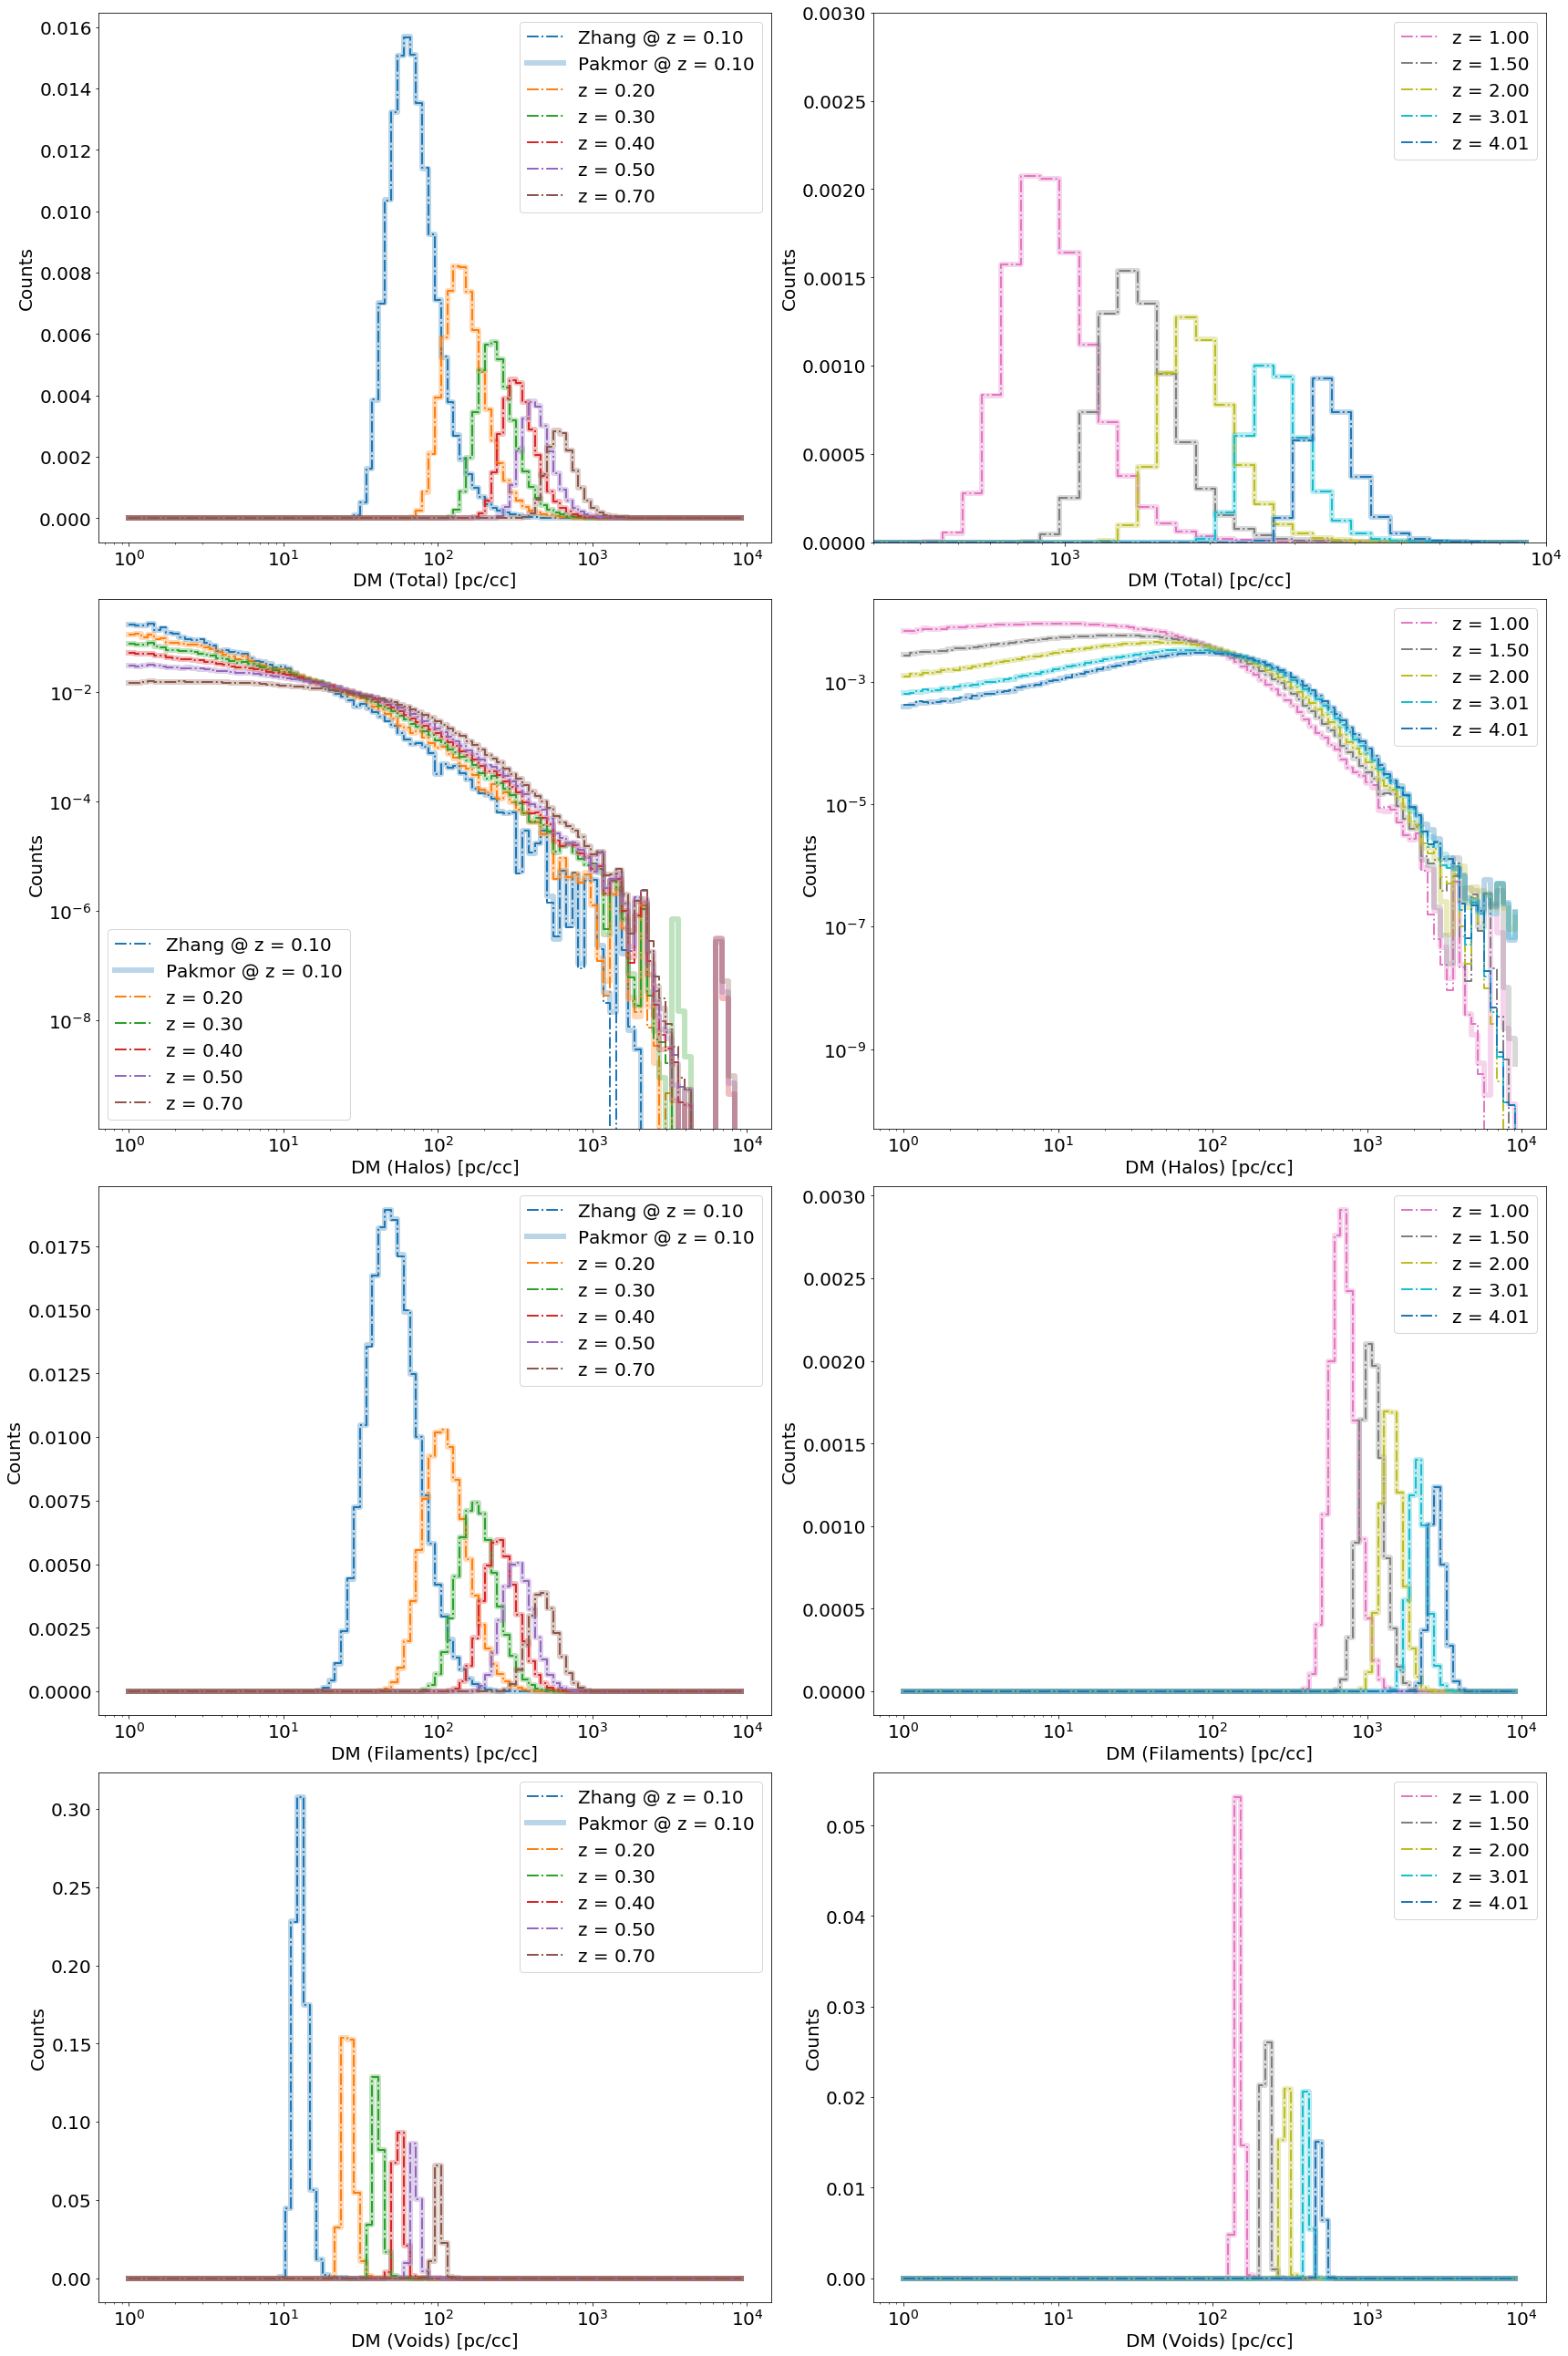

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


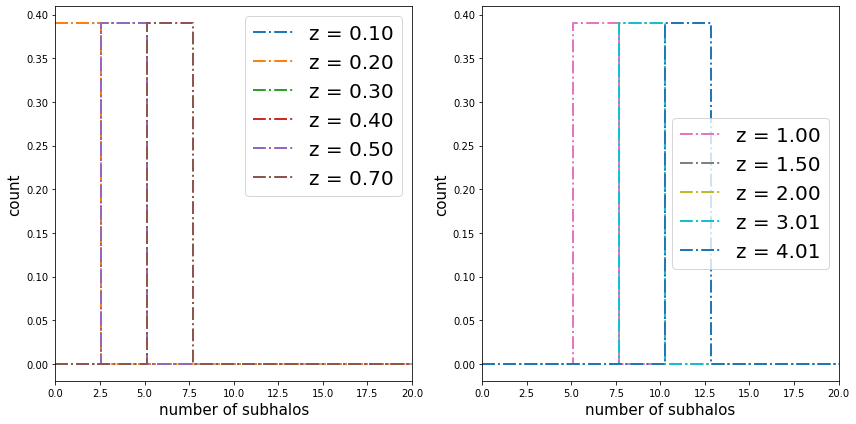

In [169]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

###################
#Initialise figure#
###################

fig = plt.figure(figsize=(24,36))

ax1 = fig.add_subplot(421)
ax1.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(422)
ax2.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

ax3 = fig.add_subplot(423)
ax3.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

ax4 = fig.add_subplot(424)
ax4.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax4.set_ylabel('Counts',fontsize=20)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)

ax5 = fig.add_subplot(425)
ax5.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax5.set_ylabel('Counts',fontsize=20)
ax5.set_xscale('log')
ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)

ax6 = fig.add_subplot(426)
ax6.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax6.set_ylabel('Counts',fontsize=20)
ax6.set_xscale('log')
ax6.tick_params(axis='x', labelsize=20)
ax6.tick_params(axis='y', labelsize=20)

ax7 = fig.add_subplot(427)
ax7.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax7.set_ylabel('Counts',fontsize=20)
ax7.set_xscale('log')
ax7.tick_params(axis='x', labelsize=20)
ax7.tick_params(axis='y', labelsize=20)

ax8 = fig.add_subplot(428)
ax8.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax8.set_ylabel('Counts',fontsize=20)
ax8.set_xscale('log')
ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)

#############
#Plot Totals#
#############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.step(x=bin_edges[:-1], y=counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)
    
############
#Plot Halos#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))        
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))        
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6,color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax4.step(x=bin_edges[:-1], y=Hal_counts_Zhang[i], where='post',  alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax4.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post',  alpha=0.3, lw=6, color='C{0}'.format(i-1))

    ax3.legend(fontsize=20)
    ax4.legend(fontsize=20)
    
################
#Plot Filaments#
################

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post',lw=6, alpha=0.3, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax6.step(x=bin_edges[:-1], y=Fil_counts_Zhang[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax6.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', lw=6, alpha=0.3, color='C{0}'.format(i-1))
        
    ax5.legend(fontsize=20)
    ax6.legend(fontsize=20)

############
#Plot Voids#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='Zhang @ z = {0:.2f}'.format(snap_z_list[i]))
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax8.step(x=bin_edges[:-1], y=Voi_counts_Zhang[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax8.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    ax7.legend(fontsize=20)
    ax8.legend(fontsize=20)

plt.tight_layout()
print('Saving LSS_Analysis_Hists_{0}.png'.format(sim_to_load))
plt.savefig('LSS_Analysis_Hists_{0}.png'.format(sim_to_load),format='png')
plt.show()


#Histograms of impact factor

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('number of subhalos',fontsize=15)
ax1.set_ylabel('count',fontsize=15)
ax1.set_xlim([0,20])
ax2 = fig.add_subplot(122)
ax2.set_xlabel('number of subhalos',fontsize=15)
ax2.set_ylabel('count',fontsize=15)
ax2.set_xlim([0,20])

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        print(i,snap_z_list[i])
        ax1.step(x=if_bin_edges[:-1], y=counts_IF[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax1.step(x=if_bin_edges[:-1], y=counts_IF[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.step(x=if_bin_edges[:-1], y=counts_IF[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))

    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)

plt.tight_layout()
plt.savefig('IF_Analysis_Hists_{0}.png'.format(sim_to_load),format='png')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676
Saving LSS_Analysis_Hists_TNG300-1_Fach.png


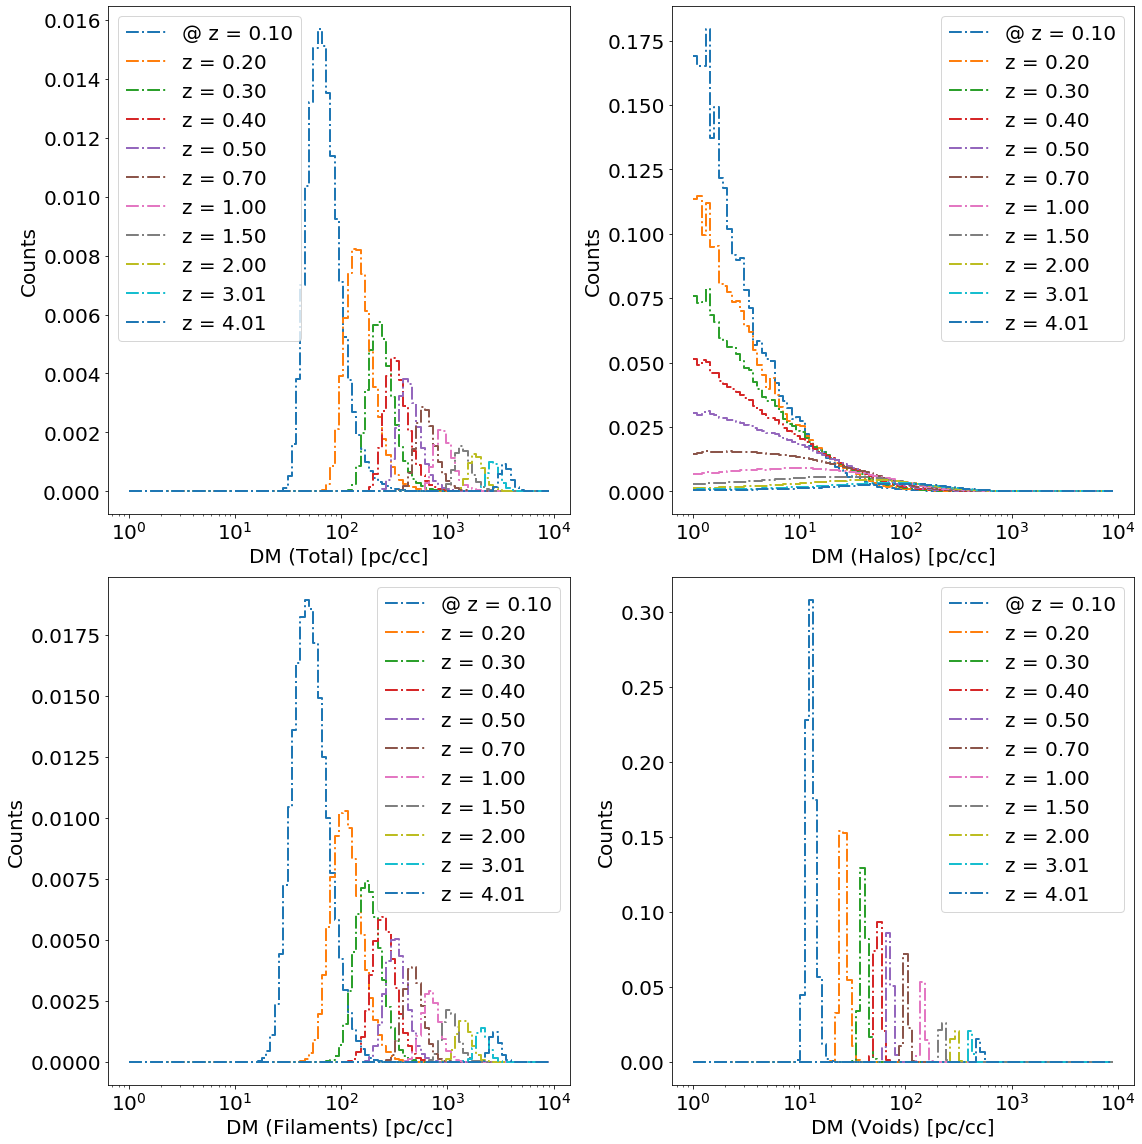

In [170]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

###################
#Initialise figure#
###################

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(221)
ax1.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

#ax2 = fig.add_subplot(222)
#ax2.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
#ax2.set_ylabel('Counts',fontsize=20)
#ax2.set_xscale('log')
#ax2.set_ylim([0,0.003])
#ax2.set_xlim([4e2,1e4])
#ax2.tick_params(axis='x', labelsize=20)
#ax2.tick_params(axis='y', labelsize=20)

ax3 = fig.add_subplot(222)
ax3.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_xscale('log')
#ax3.set_yscale('log')
#ax3.set_xlim([0,100])
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

#ax4 = fig.add_subplot(224)
#ax4.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
#ax4.set_ylabel('Counts',fontsize=20)
#ax4.set_xscale('log')
#ax4.set_yscale('log')
#ax4.tick_params(axis='x', labelsize=20)
#ax4.tick_params(axis='y', labelsize=20)

ax5 = fig.add_subplot(223)
ax5.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax5.set_ylabel('Counts',fontsize=20)
ax5.set_xscale('log')
ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)

#ax6 = fig.add_subplot(226)
#ax6.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
#ax6.set_ylabel('Counts',fontsize=20)
#ax6.set_xscale('log')
#ax6.tick_params(axis='x', labelsize=20)
#ax6.tick_params(axis='y', labelsize=20)

ax7 = fig.add_subplot(224)
ax7.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax7.set_ylabel('Counts',fontsize=20)
ax7.set_xscale('log')
ax7.tick_params(axis='x', labelsize=20)
ax7.tick_params(axis='y', labelsize=20)

#ax8 = fig.add_subplot(228)
#ax8.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
#ax8.set_ylabel('Counts',fontsize=20)
#ax8.set_xscale('log')
#ax8.tick_params(axis='x', labelsize=20)
#ax8.tick_params(axis='y', labelsize=20)

#############
#Plot Totals#
#############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='@ z = {0:.2f}'.format(snap_z_list[i]))
        #ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax2.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1))

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    #ax2.legend(fontsize=20)
    
############
#Plot Halos#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    if i==1:
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=1, lw=2,ls='-.', color='C{0}'.format(i-1),label='@ z = {0:.2f}'.format(snap_z_list[i]))        
        #ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))        
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=1, lw=2,ls='-.',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6,color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post',  alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax4.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post',  alpha=0.3, lw=6, color='C{0}'.format(i-1))

    ax3.legend(fontsize=20)
    #ax4.legend(fontsize=20)
    
################
#Plot Filaments#
################

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='@ z = {0:.2f}'.format(snap_z_list[i]))
        #ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post',lw=6, alpha=0.3, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', ls='-.',lw=2, alpha=1, color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax6.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', lw=6, alpha=0.3, color='C{0}'.format(i-1))
        
    ax5.legend(fontsize=20)
    #ax6.legend(fontsize=20)

############
#Plot Voids#
############

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='@ z = {0:.2f}'.format(snap_z_list[i]))
        #ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
    elif (i>1)&(i<7):
        print(i,snap_z_list[i])
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    elif i>=7:
        print(i,snap_z_list[i])
        ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=1, lw=2, ls='-.', color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        #ax8.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1))
    ax7.legend(fontsize=20)
    #ax8.legend(fontsize=20)

plt.tight_layout()
print('Saving LSS_Analysis_Hists_{0}_Fach.png'.format(sim_to_load))
plt.savefig('LSS_Analysis_Hists_{0}_Fach.png'.format(sim_to_load),format='png')
plt.show()



# Redshift-0.1 version for fachbeirat talk

1 0.09940180263022191


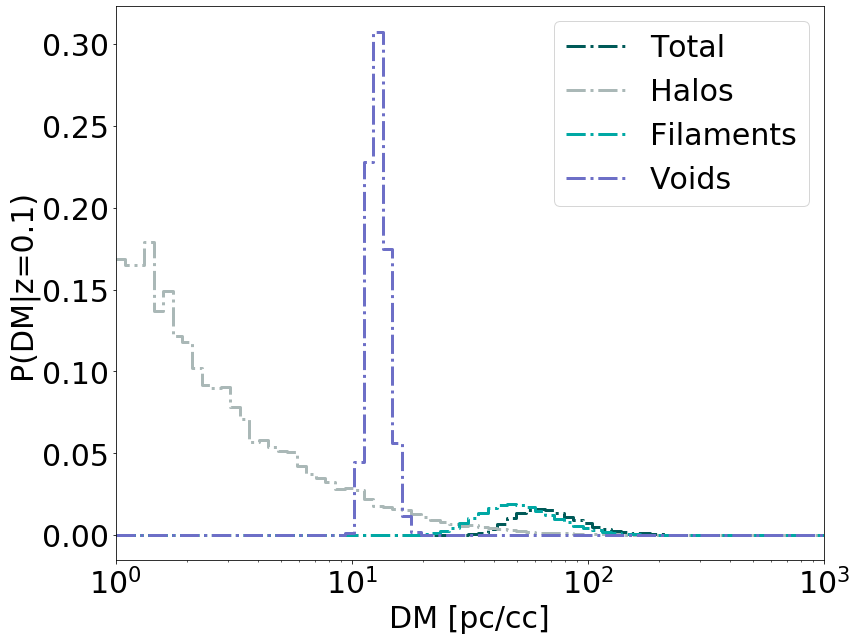

In [171]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)

ax1.set_xlabel('DM [pc/cc]',fontsize=30)
ax1.set_ylabel('P(DM|z=0.1)',fontsize=30)
ax1.set_xscale('log')
#ax1.set_ylim([0,0.02])
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

#Total DM

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==1:
        print(i,snap_z_list[i])
        ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=1, lw=3,ls='-.',color='#005a58'.format(i-1),label='Total'.format(snap_z_list[i]))
        #ax1.step(x=bin_edges[:-1], y=counts_Pakmor[i], where='post', alpha=0.3,lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))

#Halos
        
for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==1:
        ax1.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=1, lw=3,ls='-.', color='#aab8b7'.format(i-1),label='Halos'.format(snap_z_list[i]))        
        #ax3.step(x=bin_edges[:-1], y=Hal_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))        

#Filaments

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==1:
        ax1.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=1, lw=3, ls='-.', color='#00a8a4'.format(i-1),label='Filaments'.format(snap_z_list[i]))
        #ax5.step(x=bin_edges[:-1], y=Fil_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
        
        
#voids

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==1:
        ax1.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=1, lw=3, ls='-.', color='#6d6fc7'.format(i-1),label='Voids'.format(snap_z_list[i]))
        #ax7.step(x=bin_edges[:-1], y=Voi_counts_Pakmor[i], where='post', alpha=0.3, lw=6, color='C{0}'.format(i-1),label='Pakmor @ z = {0:.2f}'.format(snap_z_list[i]))
        plt.legend(fontsize=30)
#ax1.set_yscale('log')
ax1.set_xlim([1,1000])
plt.tight_layout()
plt.savefig('Fach_talk_hist.png',format='png')

# Plot the fits from Zhang+20

In [172]:
############
#Initialise#
############

xarr = np.linspace(0,10000,10000)

alpha=3
beta=3
A = np.array([0.04721,
              0.005693,
              0.003584,
              0.002876,
              0.002423,
              0.001880,
              0.001456,
              0.001098,
              0.0009672,
              0.0008968,
              0.0008826]) #from Zhang+20 table 1
C0 = np.array([-13.17,
               -1.008,
               0.596,
               1.010,
               1.127,
               1.170,
               1.189,
               1.163,
               1.162,
               1.119,
               1.092]) #from Zhang+20 table 1
sigmaDM = np.array([2.554,
                    1.118,
                    0.7043,
                    0.5158,
                    0.4306,
                    0.3595,
                    0.3044,
                    0.2609,
                    0.2160,
                    0.1566,
                    0.1233]) #from Zhang+20 table 1

##############
#Create delta#
##############

#Note: I was unsure what <DMIGM> should go into the data so I did two tests below:

#Test 1: <DMIGM> is the mean of my DM IGM values
#Test 2: <DMIGM> is the value from the macquart relation (i.e. <DMcosm)

########
#Test 1#
########

Delta_mydata_Zhang  = np.array([xarr/i for i in mean_cDM_arr_Zhang[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data
Delta_mydata_Pakmor = np.array([xarr/i for i in mean_cDM_arr_Pakmor[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data

########
#Test 2#
########

Delta_macq = np.array([xarr/i for i in np.array(cosm_theory_2)[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the macquart relation

print('my data shape:{0}'.format(Delta_mydata_Zhang.shape))
print('macquart data shape:  {0}'.format(Delta_macq.shape))
print('A shape: {0}'.format(A.shape))
print('sigma DM shape: {0}'.format(sigmaDM.shape))
print('C0 shape: {0}'.format(C0.shape))

####################################
#create the P curves for each Delta#
####################################

########
#Test 1#
########

P_mydata_Zhang  = (A[:,None]*(Delta_mydata_Zhang)**(-1*beta))*np.exp(-1*((((Delta_mydata_Zhang**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))
P_mydata_Pakmor = (A[:,None]*(Delta_mydata_Pakmor)**(-1*beta))*np.exp(-1*((((Delta_mydata_Pakmor**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))

########
#Test 2#
########

P_macq=(A[:,None]*(Delta_macq)**(-1*beta))*np.exp(-1*((((Delta_macq**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))



my data shape:(11, 10000)
macquart data shape:  (11, 10000)
A shape: (11,)
sigma DM shape: (11,)
C0 shape: (11,)


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in multiply
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in power
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in multiply


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


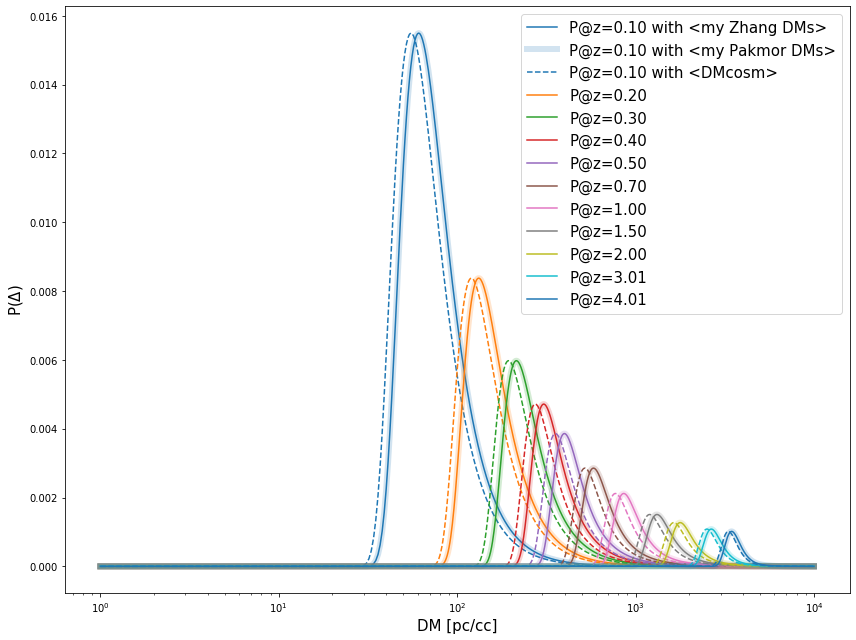

In [173]:
######
#plot#
######

#################
#Initialise plot#
#################
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('DM [pc/cc]',fontsize=15)
ax.set_ylabel('P($\Delta$)',fontsize=15)
ax.set_xscale('log')


#################
#plot the curves#
#################

for i in range(P_mydata_Zhang.shape[0]):
    if i==0:
        ax.plot(xarr,P_mydata_Zhang[i],color='C{0}'.format(i),label='P@z={0:.2f} with <my Zhang DMs>'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_mydata_Pakmor[i],color='C{0}'.format(i), linewidth=6, alpha=0.2, label='P@z={0:.2f} with <my Pakmor DMs>'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i),label='P@z={0:.2f} with <DMcosm>'.format(snap_z_list[1:][i]))
    elif i>0:
        ax.plot(xarr,P_mydata_Zhang[i],color='C{0}'.format(i),label='P@z={0:.2f}'.format(snap_z_list[1:][i]))
        ax.plot(xarr,P_mydata_Pakmor[i],color='C{0}'.format(i),lw=6,alpha=0.2)
        ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i))

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Zhang_Fits.png'.format(sim_to_load),format='png')
plt.show()
#print(Delta)

Result: Unsure which mean to use. This should be discussed with Laura as our values are actually different to Zhangs, and so these curves might also differ...

# Overplot the fits on the histograms

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832


No handles with labels found to put in legend.
No handles with labels found to put in legend.


6 0.7001063537185233
7 0.9972942257819404
8 1.4955121664955557
9 2.0020281392528516
10 3.008131071630377
11 4.0079451114652676


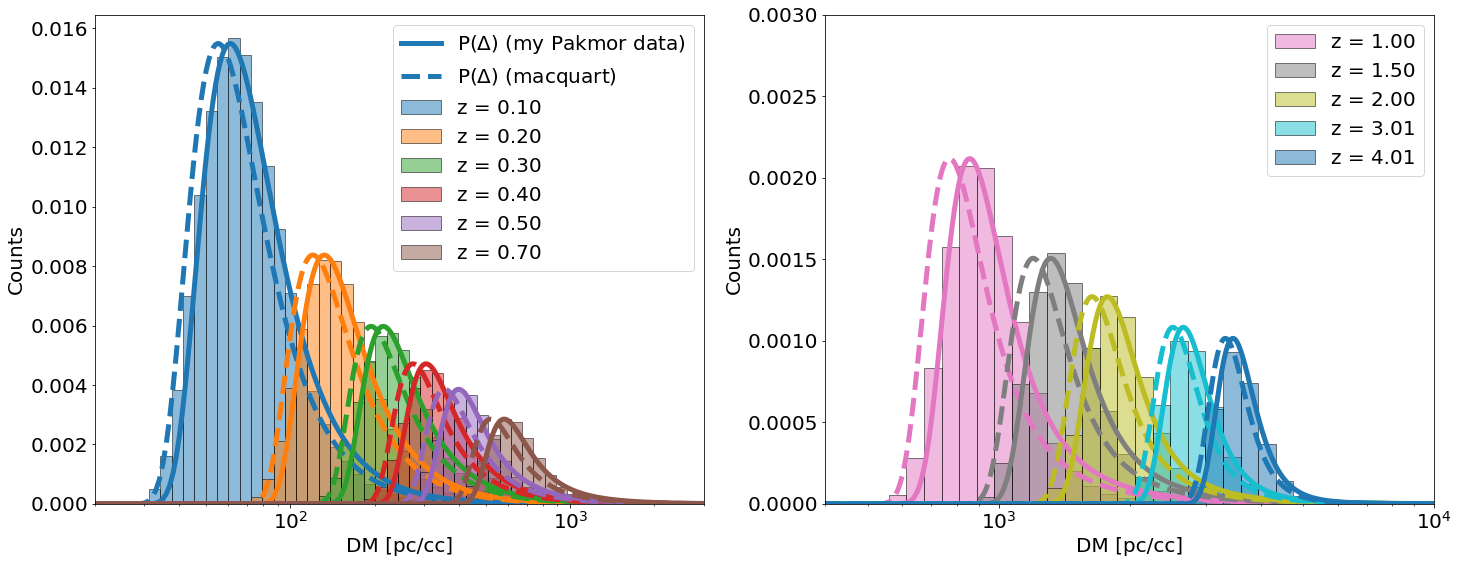

In [174]:
##################
#Initialise plots#
##################

fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.set_xlim([2e1,3e3])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

######################
#Perform the plotting#
######################

for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (my Pakmor data)')
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (macquart)')
        
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5)
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts_Pakmor[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.plot(xarr,P_mydata_Pakmor[i-1],color='C{0}'.format(i-1),lw=5)
        ax2.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)

plt.tight_layout
plt.savefig('{0}_Zhang_Fit_Data_Comparisons.png'.format(sim_to_load),format='png')
plt.show()


# Plot histograms in 2d

(12, 99)
(100,)
(12,)
0.0 0.30765092794437127


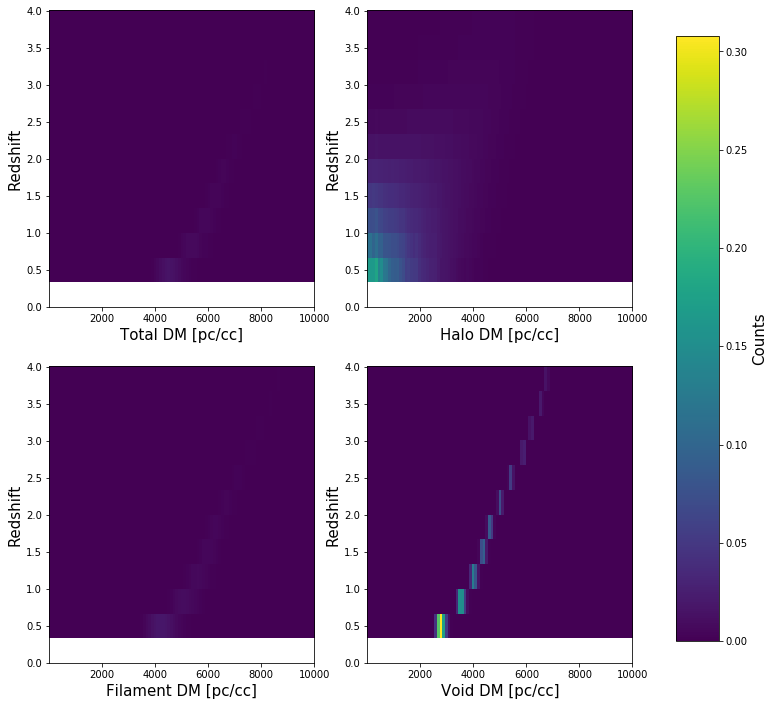

In [175]:
#original data
print(counts_Pakmor.shape) # the histograms
print(bin_edges.shape) # the edges of the bins of these histograms
print(np.array(snap_z_list).shape) # the redshifts these snapshots were taken at

#initialise figure
fig=plt.figure(figsize=(12,12))

ax1=fig.add_subplot(221)
ax1.set_ylabel('Redshift',fontsize=15)
ax1.set_xlabel('Total DM [pc/cc]',fontsize=15)

ax2=fig.add_subplot(222)
ax2.set_ylabel('Redshift',fontsize=15)
ax2.set_xlabel('Halo DM [pc/cc]',fontsize=15)

ax3=fig.add_subplot(223)
ax3.set_ylabel('Redshift',fontsize=15)
ax3.set_xlabel('Filament DM [pc/cc]',fontsize=15)

ax4=fig.add_subplot(224)
ax4.set_ylabel('Redshift',fontsize=15)
ax4.set_xlabel('Void DM [pc/cc]',fontsize=15)

#extent of the x,y axis
extent = [bin_edges[0],bin_edges[-1],snap_z_list[0],snap_z_list[-1]] 

# find minimum of minima & maximum of maxima for consistent colorbar across subplots
minmin = np.min([np.nanmin(counts_Pakmor),
                 np.nanmin(Hal_counts_Pakmor),
                 np.nanmin(Fil_counts_Pakmor),
                 np.nanmin(Voi_counts_Pakmor)])

maxmax = np.max([np.nanmax(counts_Pakmor),
                 np.nanmax(Hal_counts_Pakmor),
                 np.nanmax(Fil_counts_Pakmor),
                 np.nanmax(Voi_counts_Pakmor)])
print(minmin,maxmax)

im1 = ax1.imshow(counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im2 = ax2.imshow(Hal_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im3 = ax3.imshow(Fil_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)
im4 = ax4.imshow(Voi_counts_Pakmor,aspect='auto',origin='lower',extent=extent,vmin=minmin, vmax=maxmax)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar=fig.colorbar(im1, cax=cbar_ax)
cbar.set_label('Counts',fontsize=15)

plt.tight_layout
plt.savefig('{0}_Zhang_Data_2D.png'.format(sim_to_load),format='png')
plt.show()


# Plot the other axis

(12, 99)
(99,)
(12,)


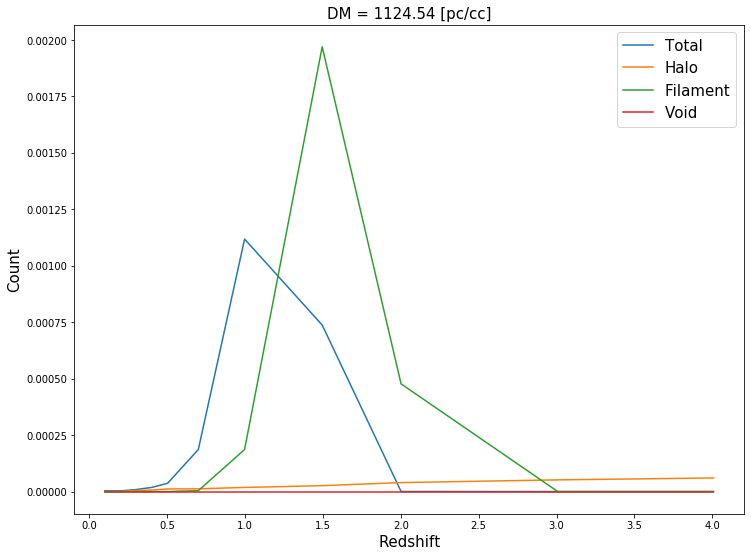

In [176]:
print(counts_Pakmor.shape)
print(counts_Pakmor[0].shape)
print(counts_Pakmor[:,0].shape)


fig = plt.figure(figsize=(12,9))
ax=fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('Count',fontsize=15)


for i in range(counts_Pakmor.shape[1]):
    
    
    if i==75:
        ax.set_title('DM = {0:.2f} [pc/cc]'.format((bin_edges[i]+bin_edges[i+1])/2),fontsize=15)

        ax.plot(snap_z_list,counts_Pakmor[:,i],label='Total')
        ax.plot(snap_z_list,Hal_counts_Pakmor[:,i],label='Halo')
        ax.plot(snap_z_list,Fil_counts_Pakmor[:,i],label='Filament')
        ax.plot(snap_z_list,Voi_counts_Pakmor[:,i],label='Void')

plt.legend(fontsize=15)   
plt.show()



# Fitting to LSS histograms

# Voids

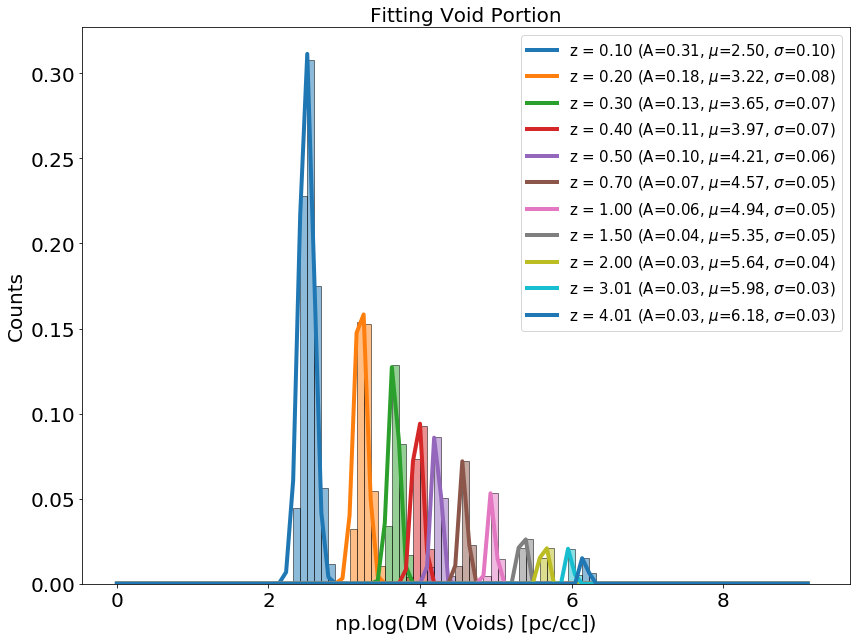

In [177]:
#initialise figure
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_title('Fitting Void Portion',fontsize=20)
ax1.set_xlabel('np.log(DM (Voids) [pc/cc])',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
#ax1.set_xscale('log')
#ax1.set_xlim([0,1000])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)): #loop over redshifts
    
    #####################
    #extract data to fit#
    #####################
    
    x=np.log(bin_edges[:-1]) #x values of histograms (log to preserve gaussian shape)
    #x=bin_edges[:-1] #x values of histograms (log to preserve gaussian shape)
    #y=Hal_counts_Pakmor[i] #halo portion
    #y=Fil_counts_Pakmor[i] #filament portion
    y=Voi_counts_Pakmor[i] #void portions
    

    ######################################
    #only fit for snapshot 91 and onwards#
    ######################################
    
    if i>=1:
        
        ###########################################
        #guess initial parameters for gaussian fit#
        ###########################################
        
        amp = y[np.argmax(y)] #guess amplitude of curve: height of largest bin
        mean = x[np.argmax(y)] #guess mean: DM of largest bin
        stddev=1
        
        #####################
        #Perform the fitting#
        #####################
        
        g_init = models.Gaussian1D(amplitude=amp, mean=mean, stddev=stddev)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, x, y)
        
        ##############
        #plot the fit#
        ##############
        
        ax1.bar(x=x,height=y,width=np.diff(np.log(bin_edges)), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1))
        ax1.plot(x, g(x), color='C{0}'.format(i-1),lw=4,label='z = {0:.2f} (A={1:.2f}, $\mu$={2:.2f}, $\sigma$={3:.2f})'.format(snap_z_list[i],g.amplitude.value,g.mean.value,g.stddev.value))
        
        plt.legend(fontsize=15)
        
plt.tight_layout()
plt.savefig('LSS_Fits_Void_Gaussian.png',format='png')
    


# Filaments

1 3.8143833863739753 0.01891557958786759
2 4.651687056553628 0.010268036428970562
3 5.11685576220899 0.00742592695283672
4 5.488990726733281 0.0059439941689265014
5 5.7680919501264984 0.005036996178062842
6 6.140226914650789 0.0038681828908501427
7 6.51236187917508 0.0029133466224327657
8 6.884496843699369 0.0021047759518192407
9 7.163598067092587 0.0016920194523946364
10 7.628766772747951 0.0014015511855578389
11 7.907867996141168 0.0012346481463538215


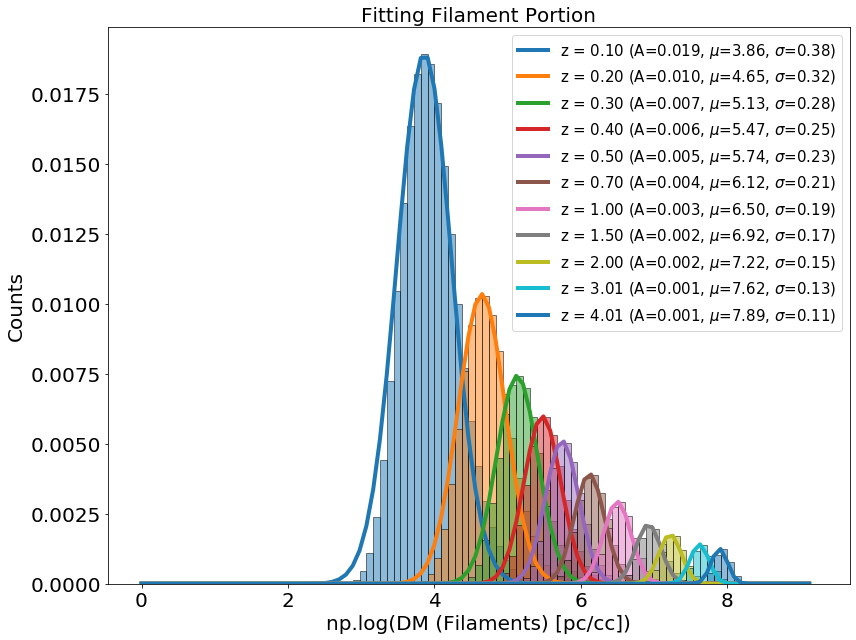

In [178]:
#initialise figure
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(111)
ax1.set_title('Fitting Filament Portion',fontsize=20)
ax1.set_xlabel('np.log(DM (Filaments) [pc/cc])',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
#ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)): #loop over redshifts
    
    #####################
    #extract data to fit#
    #####################
    
    x=np.log(bin_edges[:-1]) #x values of histograms (log to preserve gaussian shape)
    #x=bin_edges[:-1] #x values of histograms
    #y=Hal_counts_Pakmor[i] #halo portion
    y=Fil_counts_Pakmor[i] #filament portion
    #y=Voi_counts_Pakmor[i] #void portions
    

    ######################################
    #only fit for snapshot 91 and onwards#
    ######################################
    
    if i>=1:
        
        ###########################################
        #guess initial parameters for gaussian fit#
        ###########################################
        
        amp = y[np.argmax(y)] #guess amplitude of curve: height of largest bin
        mean = x[np.argmax(y)] #guess mean: DM of largest bin
        print(i,mean,amp)
        stddev=1
        
        #####################
        #Perform the fitting#
        #####################
        
        g_init = models.Gaussian1D(amplitude=amp, mean=mean, stddev=stddev)
        fit_g = fitting.LevMarLSQFitter()
        g = fit_g(g_init, x, y)
        
        ##############
        #plot the fit#
        ##############
        
        #ax1.scatter(x,y)
        ax1.bar(x=x,height=y,width=np.diff(np.log(bin_edges)), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1))
        ax1.plot(x, g(x), color='C{0}'.format(i-1),lw=4,label='z = {0:.2f} (A={1:.3f}, $\mu$={2:.2f}, $\sigma$={3:.2f})'.format(snap_z_list[i],g.amplitude.value,g.mean.value,g.stddev.value))
        
        plt.legend(fontsize=15)
        
plt.tight_layout()
plt.savefig('LSS_Fits_Filament_Gaussian.png',format='png')